# ForesightX - Stock Market Prediction Pipeline
## ML Pipeline Stages:
1. **Data Ingestion** - Fetch historical stock data
2. **EDA** - Exploratory Data Analysis
3. **Pre-processing** - Clean and prepare data
4. **Feature Engineering & Selection** - Create and select relevant features
5. **Model Training** - Train time-series and ML models
6. **Model Evaluation** - Evaluate model performance

---
## 1. DATA INGESTION
Fetch long historical stock market data for training

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration for data ingestion
STOCK_SYMBOL = "AAPL"  # Change this to any stock ticker (e.g., "TSLA", "GOOGL", "MSFT")
START_DATE = "2010-01-01"  # Fetch as much historical data as possible
END_DATE = datetime.now().strftime("%Y-%m-%d")  # Up to today

print(f"Configuration:")
print(f"  Stock Symbol: {STOCK_SYMBOL}")
print(f"  Date Range: {START_DATE} to {END_DATE}")

Configuration:
  Stock Symbol: AAPL
  Date Range: 2010-01-01 to 2025-12-14


In [3]:
# Fetch historical stock data
def fetch_stock_data(symbol, start_date, end_date):
    """
    Fetch historical stock data using yfinance
    
    Parameters:
    - symbol: Stock ticker symbol (e.g., 'AAPL', 'GOOGL')
    - start_date: Start date in 'YYYY-MM-DD' format
    - end_date: End date in 'YYYY-MM-DD' format
    
    Returns:
    - DataFrame with OHLCV data
    """
    try:
        print(f"Fetching data for {symbol}...")
        stock = yf.Ticker(symbol)
        
        # Download historical data
        df = stock.history(start=start_date, end=end_date)
        
        if df.empty:
            print(f"No data found for {symbol}")
            return None
        
        # Reset index to make Date a column
        df.reset_index(inplace=True)
        
        # Get additional stock info
        info = stock.info
        company_name = info.get('longName', symbol)
        sector = info.get('sector', 'N/A')
        industry = info.get('industry', 'N/A')
        
        print(f"\n✓ Data fetched successfully!")
        print(f"  Company: {company_name}")
        print(f"  Sector: {sector}")
        print(f"  Industry: {industry}")
        print(f"  Total records: {len(df)}")
        print(f"  Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
        print(f"  Columns: {list(df.columns)}")
        
        return df
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Fetch the data
df_raw = fetch_stock_data(STOCK_SYMBOL, START_DATE, END_DATE)

Fetching data for AAPL...

✓ Data fetched successfully!
  Company: Apple Inc.
  Sector: Technology
  Industry: Consumer Electronics
  Total records: 4012
  Date range: 2010-01-04 to 2025-12-12
  Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

✓ Data fetched successfully!
  Company: Apple Inc.
  Sector: Technology
  Industry: Consumer Electronics
  Total records: 4012
  Date range: 2010-01-04 to 2025-12-12
  Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']


In [4]:
# Display first and last few rows
if df_raw is not None:
    print("\n📊 First 5 rows:")
    display(df_raw.head())
    
    print("\n📊 Last 5 rows:")
    display(df_raw.tail())
    
    print("\n📈 Data Summary:")
    print(df_raw.info())
    
    print("\n📉 Statistical Summary:")
    display(df_raw.describe())


📊 First 5 rows:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04 00:00:00-05:00,6.400988,6.433079,6.369498,6.418383,493729600,0.0,0.0
1,2010-01-05 00:00:00-05:00,6.436077,6.465768,6.395588,6.429479,601904800,0.0,0.0
2,2010-01-06 00:00:00-05:00,6.429481,6.454974,6.320614,6.327212,552160000,0.0,0.0
3,2010-01-07 00:00:00-05:00,6.350603,6.358101,6.269627,6.315513,477131200,0.0,0.0
4,2010-01-08 00:00:00-05:00,6.307116,6.358101,6.269928,6.357501,447610800,0.0,0.0



📊 Last 5 rows:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
4007,2025-12-08 00:00:00-05:00,278.130005,279.670013,276.149994,277.890015,38211800,0.0,0.0
4008,2025-12-09 00:00:00-05:00,278.160004,280.029999,276.920013,277.179993,32193300,0.0,0.0
4009,2025-12-10 00:00:00-05:00,277.750000,279.750000,276.440002,278.779999,33038300,0.0,0.0
4010,2025-12-11 00:00:00-05:00,279.100006,279.589996,273.809998,278.029999,33248000,0.0,0.0
4011,2025-12-12 00:00:00-05:00,277.795013,279.220001,276.820007,278.279999,38360082,0.0,0.0



📈 Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012 entries, 0 to 4011
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          4012 non-null   datetime64[ns, America/New_York]
 1   Open          4012 non-null   float64                         
 2   High          4012 non-null   float64                         
 3   Low           4012 non-null   float64                         
 4   Close         4012 non-null   float64                         
 5   Volume        4012 non-null   int64                           
 6   Dividends     4012 non-null   float64                         
 7   Stock Splits  4012 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 250.9 KB
None

📉 Statistical Summary:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4012.000000,4012.000000,4012.000000,4012.000000,4.012000e+03,4012.000000,4012.000000
mean,76.859647,77.688910,76.089651,76.926150,2.195275e+08,0.002435,0.002742
std,74.289189,75.100391,73.568120,74.375869,2.155849e+08,0.021717,0.127271
min,5.769378,5.878245,5.705796,5.759781,2.013560e+07,0.000000,0.000000
25%,18.189197,18.344924,18.040739,18.202543,7.831732e+07,0.000000,0.000000
50%,38.397443,39.017031,38.072026,38.398272,1.311560e+08,0.000000,0.000000
75%,142.125790,144.008316,140.653366,142.490593,2.906715e+08,0.000000,0.000000
max,286.200012,288.619995,283.299988,286.190002,1.880998e+09,0.260000,7.000000


In [5]:
# Save raw data to disk for later use
if df_raw is not None:
    RAW_DATA_PATH = f"../data/raw/stock_data_raw_{STOCK_SYMBOL}.csv"
    df_raw.to_csv(RAW_DATA_PATH, index=False)
    print(f"✓ Raw data saved to: {RAW_DATA_PATH}")
    print(f"  File size: {df_raw.memory_usage(deep=True).sum() / 1024:.2f} KB")

✓ Raw data saved to: ../data/raw/stock_data_raw_AAPL.csv
  File size: 250.88 KB


---
## 2. EXPLORATORY DATA ANALYSIS (EDA)
Analyze patterns, trends, and characteristics of the data

In [6]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set figure size default
plt.rcParams['figure.figsize'] = (14, 6)

print("Visualization libraries imported!")

Visualization libraries imported!


In [7]:
# Basic data quality checks
print("=" * 60)
print("DATA QUALITY ANALYSIS")
print("=" * 60)

if df_raw is not None:
    # Check for missing values
    print("\n1. Missing Values:")
    missing = df_raw.isnull().sum()
    if missing.sum() == 0:
        print("   ✓ No missing values found!")
    else:
        print(missing[missing > 0])
    
    # Check for duplicates
    print(f"\n2. Duplicate Rows: {df_raw.duplicated().sum()}")
    
    # Data types
    print("\n3. Data Types:")
    print(df_raw.dtypes)
    
    # Date range and frequency
    print(f"\n4. Date Range:")
    print(f"   Start: {df_raw['Date'].min()}")
    print(f"   End: {df_raw['Date'].max()}")
    print(f"   Total Days: {(df_raw['Date'].max() - df_raw['Date'].min()).days}")
    print(f"   Trading Days: {len(df_raw)}")
    
    # Check for zero or negative prices
    price_cols = ['Open', 'High', 'Low', 'Close']
    print("\n5. Price Validation:")
    for col in price_cols:
        if col in df_raw.columns:
            zero_neg = (df_raw[col] <= 0).sum()
            if zero_neg > 0:
                print(f"   ⚠ {col}: {zero_neg} zero/negative values")
            else:
                print(f"   ✓ {col}: All positive values")
    
    # Volume check
    if 'Volume' in df_raw.columns:
        zero_vol = (df_raw['Volume'] == 0).sum()
        print(f"\n6. Zero Volume Days: {zero_vol} ({zero_vol/len(df_raw)*100:.2f}%)")

DATA QUALITY ANALYSIS

1. Missing Values:
   ✓ No missing values found!

2. Duplicate Rows: 0

3. Data Types:
Date            datetime64[ns, America/New_York]
Open                                     float64
High                                     float64
Low                                      float64
Close                                    float64
Volume                                     int64
Dividends                                float64
Stock Splits                             float64
dtype: object

4. Date Range:
   Start: 2010-01-04 00:00:00-05:00
   End: 2025-12-12 00:00:00-05:00
   Total Days: 5821
   Trading Days: 4012

5. Price Validation:
   ✓ Open: All positive values
   ✓ High: All positive values
   ✓ Low: All positive values
   ✓ Close: All positive values

6. Zero Volume Days: 0 (0.00%)


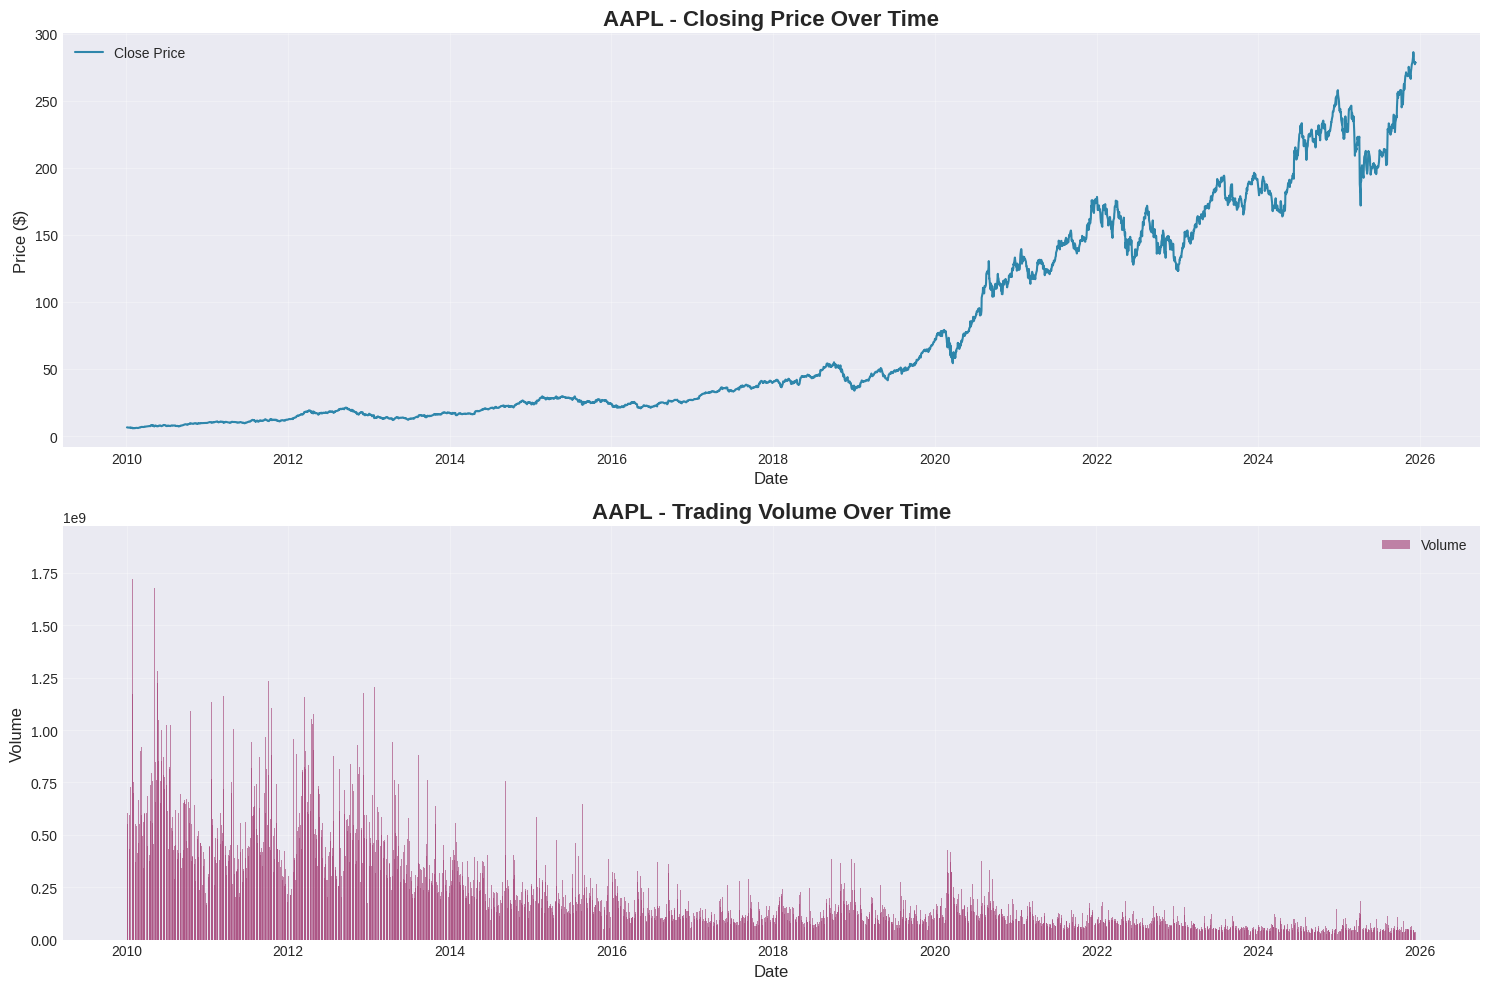


📈 Price Performance:
   Starting Price: $6.42
   Current Price: $278.28
   Total Return: 4235.67%
   All-Time High: $288.62
   All-Time Low: $5.71


In [8]:
# Price movement over time
if df_raw is not None:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Closing price over time
    axes[0].plot(df_raw['Date'], df_raw['Close'], linewidth=1.5, color='#2E86AB', label='Close Price')
    axes[0].set_title(f'{STOCK_SYMBOL} - Closing Price Over Time', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Price ($)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Volume over time
    axes[1].bar(df_raw['Date'], df_raw['Volume'], width=2, color='#A23B72', alpha=0.6, label='Volume')
    axes[1].set_title(f'{STOCK_SYMBOL} - Trading Volume Over Time', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Volume', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display key statistics
    current_price = df_raw['Close'].iloc[-1]
    start_price = df_raw['Close'].iloc[0]
    total_return = ((current_price - start_price) / start_price) * 100
    
    print(f"\n📈 Price Performance:")
    print(f"   Starting Price: ${start_price:.2f}")
    print(f"   Current Price: ${current_price:.2f}")
    print(f"   Total Return: {total_return:.2f}%")
    print(f"   All-Time High: ${df_raw['High'].max():.2f}")
    print(f"   All-Time Low: ${df_raw['Low'].min():.2f}")

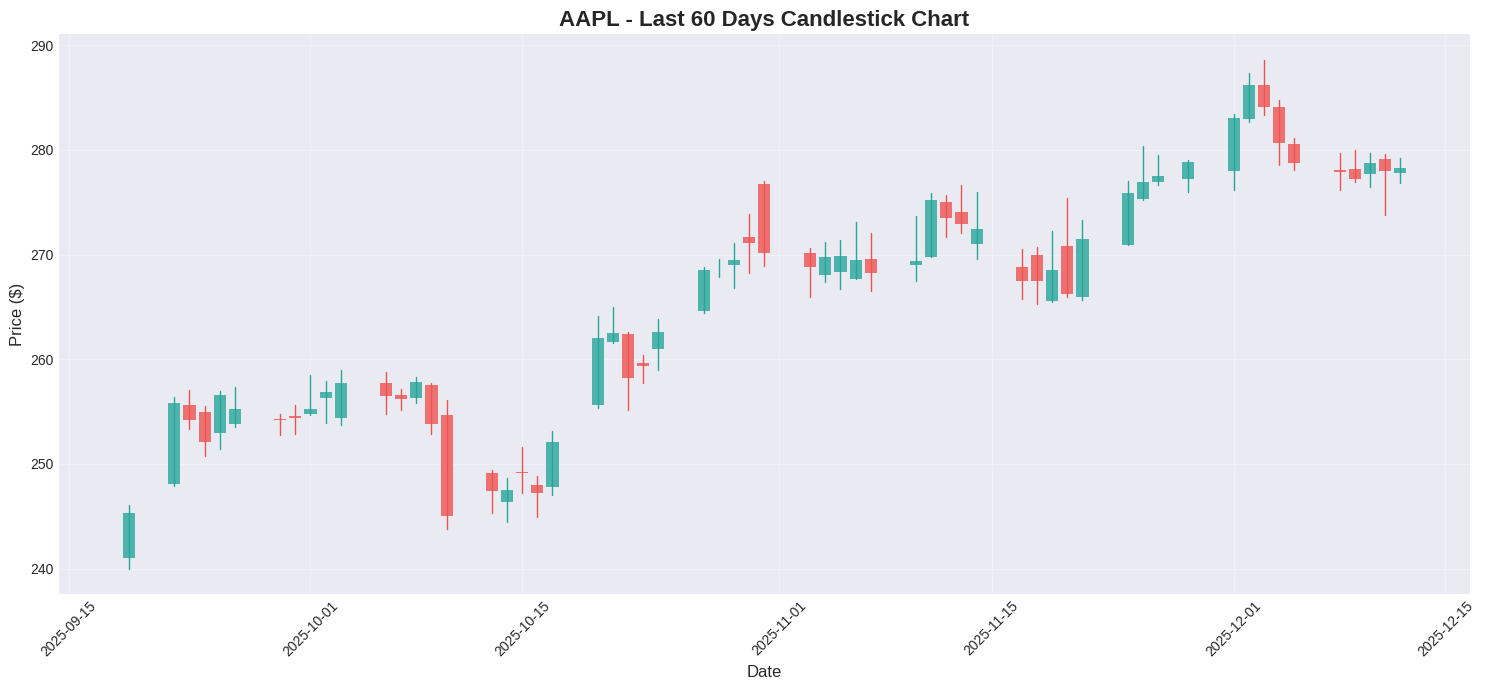


📊 Last 60 Days Statistics:
   Up Days: 32 (53.3%)
   Down Days: 28 (46.7%)
   Avg Daily Range: $4.96


In [9]:
# Candlestick pattern visualization (using OHLC)
if df_raw is not None:
    # Get last 60 days for better visibility
    recent_data = df_raw.tail(60).copy()
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Create candlestick-like visualization
    for idx, row in recent_data.iterrows():
        color = '#26A69A' if row['Close'] >= row['Open'] else '#EF5350'  # Green if up, red if down
        
        # Draw the high-low line
        ax.plot([row['Date'], row['Date']], [row['Low'], row['High']], 
                color=color, linewidth=1, solid_capstyle='round')
        
        # Draw the open-close box
        height = abs(row['Close'] - row['Open'])
        bottom = min(row['Open'], row['Close'])
        ax.bar(row['Date'], height, bottom=bottom, width=0.8, color=color, alpha=0.8)
    
    ax.set_title(f'{STOCK_SYMBOL} - Last 60 Days Candlestick Chart', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate daily statistics for recent period
    up_days = (recent_data['Close'] > recent_data['Open']).sum()
    down_days = (recent_data['Close'] < recent_data['Open']).sum()
    
    print(f"\n📊 Last 60 Days Statistics:")
    print(f"   Up Days: {up_days} ({up_days/len(recent_data)*100:.1f}%)")
    print(f"   Down Days: {down_days} ({down_days/len(recent_data)*100:.1f}%)")
    print(f"   Avg Daily Range: ${recent_data['High'].mean() - recent_data['Low'].mean():.2f}")

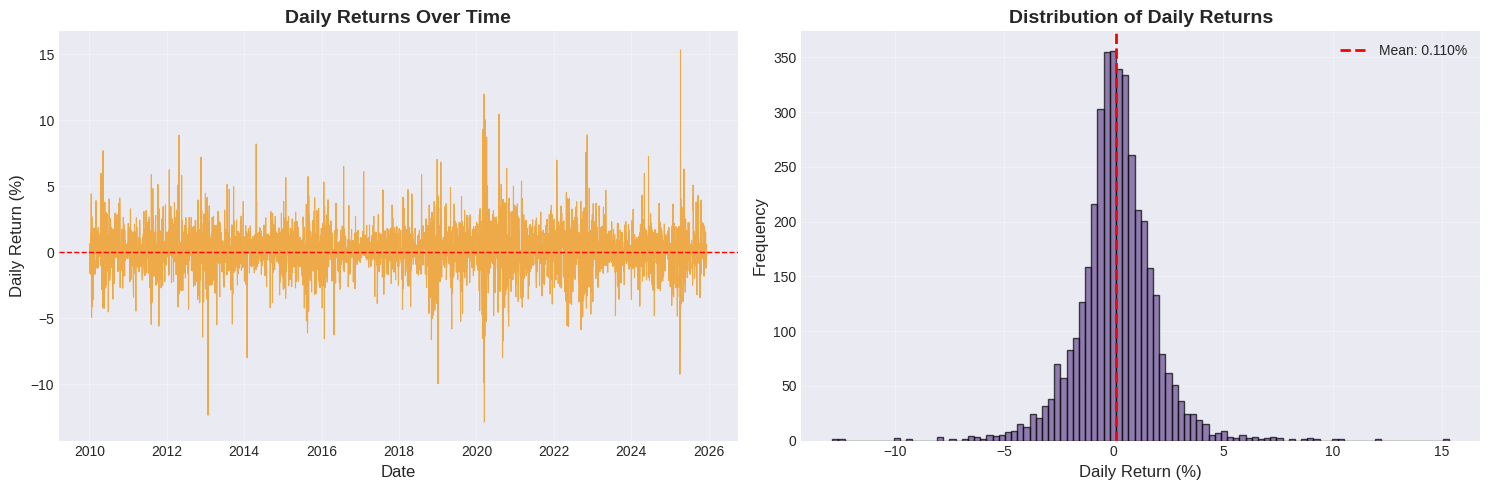


📉 Return Statistics:
   Mean Daily Return: 0.1098%
   Median Daily Return: 0.0991%
   Std Deviation: 1.7768%
   Best Day: 15.33%
   Worst Day: -12.86%
   Positive Days: 2129 (53.1%)
   Negative Days: 1875 (46.7%)


In [10]:
# Calculate daily returns and analyze distribution
if df_raw is not None:
    # Calculate daily returns
    df_raw['Daily_Return'] = df_raw['Close'].pct_change() * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Returns over time
    axes[0].plot(df_raw['Date'], df_raw['Daily_Return'], linewidth=0.8, color='#F18F01', alpha=0.7)
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0].set_title('Daily Returns Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Daily Return (%)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Distribution of returns
    axes[1].hist(df_raw['Daily_Return'].dropna(), bins=100, color='#6A4C93', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=df_raw['Daily_Return'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {df_raw["Daily_Return"].mean():.3f}%')
    axes[1].set_title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Daily Return (%)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis of returns
    print("\n📉 Return Statistics:")
    print(f"   Mean Daily Return: {df_raw['Daily_Return'].mean():.4f}%")
    print(f"   Median Daily Return: {df_raw['Daily_Return'].median():.4f}%")
    print(f"   Std Deviation: {df_raw['Daily_Return'].std():.4f}%")
    print(f"   Best Day: {df_raw['Daily_Return'].max():.2f}%")
    print(f"   Worst Day: {df_raw['Daily_Return'].min():.2f}%")
    print(f"   Positive Days: {(df_raw['Daily_Return'] > 0).sum()} ({(df_raw['Daily_Return'] > 0).sum()/len(df_raw)*100:.1f}%)")
    print(f"   Negative Days: {(df_raw['Daily_Return'] < 0).sum()} ({(df_raw['Daily_Return'] < 0).sum()/len(df_raw)*100:.1f}%)")

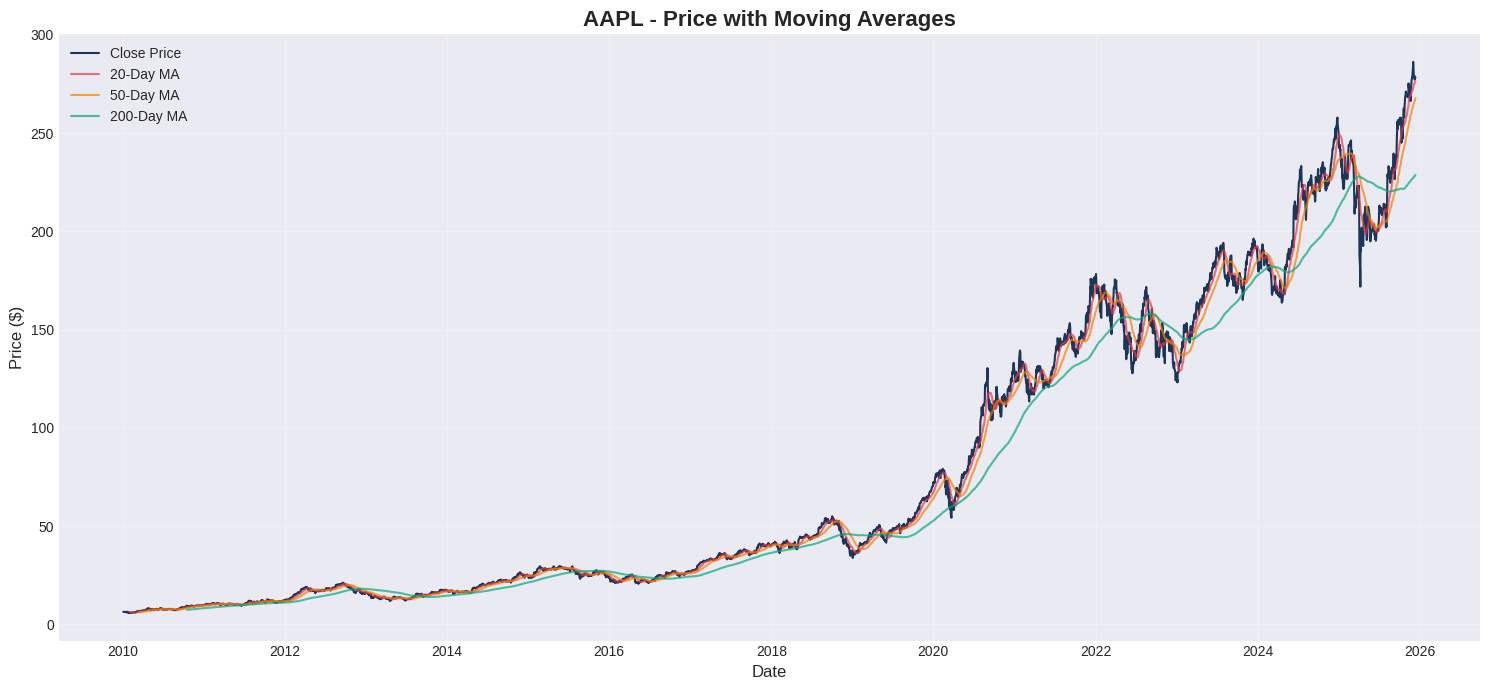


📈 Current Moving Average Positions:
   Price: $278.28
   20-Day MA: $276.30 (Above)
   50-Day MA: $267.72 (Above)
   200-Day MA: $228.62 (Above)


In [11]:
# Moving averages analysis
if df_raw is not None:
    # Calculate moving averages
    df_raw['MA_20'] = df_raw['Close'].rolling(window=20).mean()
    df_raw['MA_50'] = df_raw['Close'].rolling(window=50).mean()
    df_raw['MA_200'] = df_raw['Close'].rolling(window=200).mean()
    
    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df_raw['Date'], df_raw['Close'], label='Close Price', linewidth=1.5, color='#1D3557')
    plt.plot(df_raw['Date'], df_raw['MA_20'], label='20-Day MA', linewidth=1.5, color='#E63946', alpha=0.7)
    plt.plot(df_raw['Date'], df_raw['MA_50'], label='50-Day MA', linewidth=1.5, color='#F77F00', alpha=0.7)
    plt.plot(df_raw['Date'], df_raw['MA_200'], label='200-Day MA', linewidth=1.5, color='#06A77D', alpha=0.7)
    
    plt.title(f'{STOCK_SYMBOL} - Price with Moving Averages', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Current MA positions
    current_price = df_raw['Close'].iloc[-1]
    current_ma20 = df_raw['MA_20'].iloc[-1]
    current_ma50 = df_raw['MA_50'].iloc[-1]
    current_ma200 = df_raw['MA_200'].iloc[-1]
    
    print("\n📈 Current Moving Average Positions:")
    print(f"   Price: ${current_price:.2f}")
    print(f"   20-Day MA: ${current_ma20:.2f} ({'Above' if current_price > current_ma20 else 'Below'})")
    print(f"   50-Day MA: ${current_ma50:.2f} ({'Above' if current_price > current_ma50 else 'Below'})")
    print(f"   200-Day MA: ${current_ma200:.2f} ({'Above' if current_price > current_ma200 else 'Below'})")

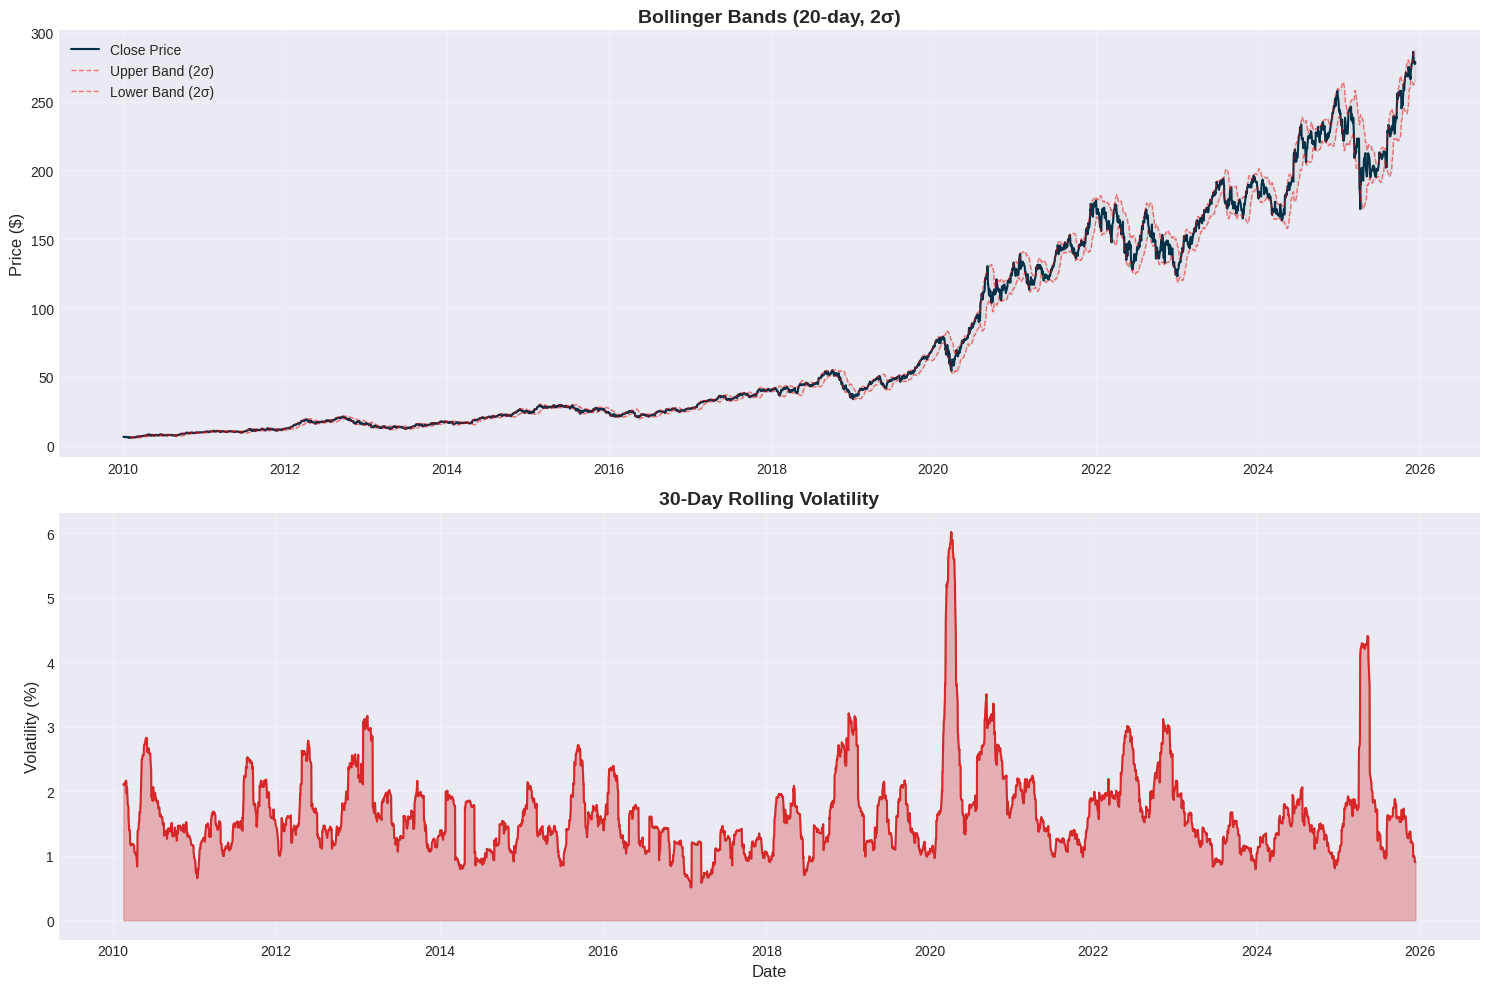


📊 Volatility Statistics:
   Current 30-Day Volatility: 0.9020%
   Average Volatility: 1.6490%
   Max Volatility: 6.0224%
   Min Volatility: 0.5085%


In [12]:
# Volatility analysis
if df_raw is not None:
    # Calculate rolling volatility (standard deviation of returns)
    df_raw['Volatility_30'] = df_raw['Daily_Return'].rolling(window=30).std()
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Price with volatility bands
    rolling_mean = df_raw['Close'].rolling(window=20).mean()
    rolling_std = df_raw['Close'].rolling(window=20).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    
    axes[0].plot(df_raw['Date'], df_raw['Close'], label='Close Price', linewidth=1.5, color='#023047')
    axes[0].plot(df_raw['Date'], upper_band, label='Upper Band (2σ)', linewidth=1, color='red', alpha=0.5, linestyle='--')
    axes[0].plot(df_raw['Date'], lower_band, label='Lower Band (2σ)', linewidth=1, color='red', alpha=0.5, linestyle='--')
    axes[0].fill_between(df_raw['Date'], upper_band, lower_band, alpha=0.1, color='gray')
    axes[0].set_title('Bollinger Bands (20-day, 2σ)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Price ($)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Volatility over time
    axes[1].plot(df_raw['Date'], df_raw['Volatility_30'], linewidth=1.5, color='#D62828')
    axes[1].fill_between(df_raw['Date'], df_raw['Volatility_30'], alpha=0.3, color='#D62828')
    axes[1].set_title('30-Day Rolling Volatility', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Volatility (%)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Volatility Statistics:")
    print(f"   Current 30-Day Volatility: {df_raw['Volatility_30'].iloc[-1]:.4f}%")
    print(f"   Average Volatility: {df_raw['Volatility_30'].mean():.4f}%")
    print(f"   Max Volatility: {df_raw['Volatility_30'].max():.4f}%")
    print(f"   Min Volatility: {df_raw['Volatility_30'].min():.4f}%")

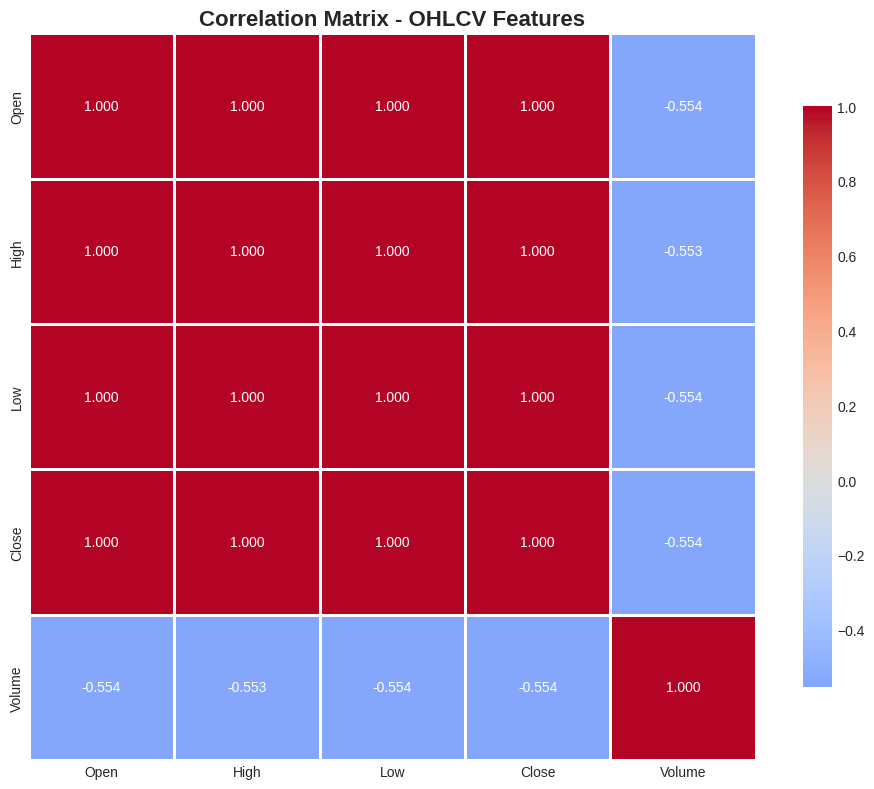


🔗 Key Correlations:
   High <-> Close: 0.9999
   Open <-> Low: 0.9999
   Low <-> Close: 0.9999
   Open <-> High: 0.9999
   High <-> Low: 0.9999


In [13]:
# Correlation analysis between OHLCV features
if df_raw is not None:
    # Select numeric columns for correlation
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    corr_data = df_raw[numeric_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - OHLCV Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n🔗 Key Correlations:")
    # Find strongest correlations (excluding diagonal)
    corr_pairs = []
    for i in range(len(corr_data.columns)):
        for j in range(i+1, len(corr_data.columns)):
            corr_pairs.append((corr_data.columns[i], corr_data.columns[j], corr_data.iloc[i, j]))
    
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr in corr_pairs[:5]:
        print(f"   {feat1} <-> {feat2}: {corr:.4f}")

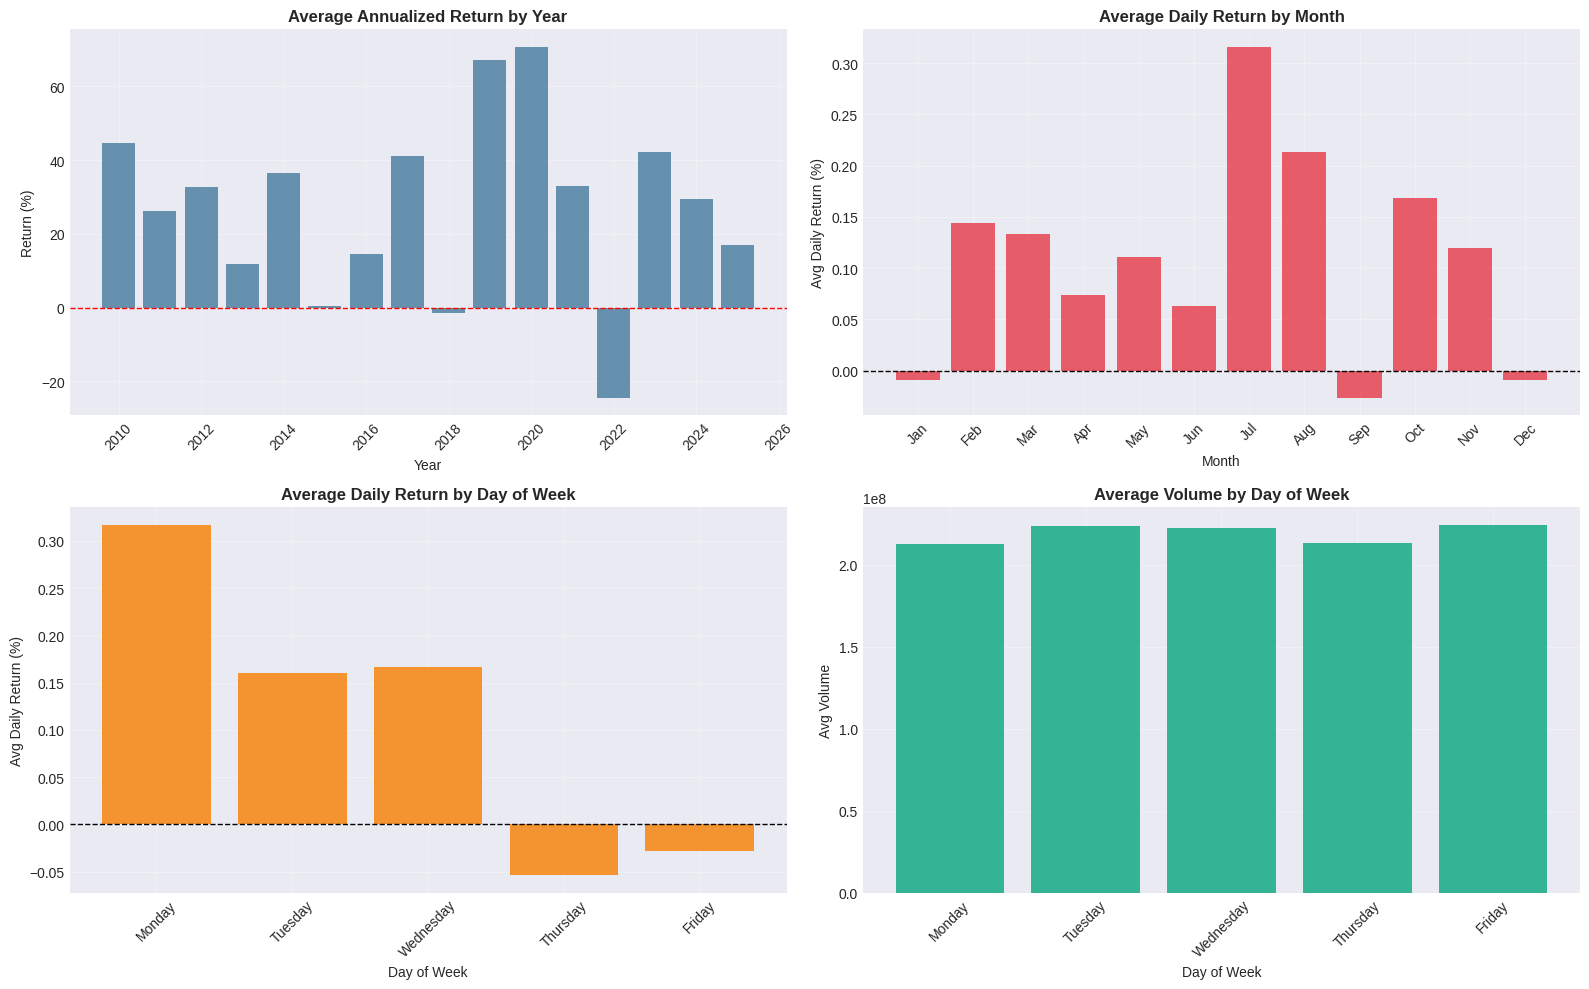


📅 Seasonal Patterns:

   Best Performing Month: Jul (0.3159%)
   Worst Performing Month: Sep (-0.0263%)

   Best Day of Week: Monday (0.3172%)
   Worst Day of Week: Thursday (-0.0540%)


In [14]:
# Trend analysis - Yearly and Monthly patterns
if df_raw is not None:
    # Extract year and month
    df_raw['Year'] = pd.to_datetime(df_raw['Date']).dt.year
    df_raw['Month'] = pd.to_datetime(df_raw['Date']).dt.month
    df_raw['Month_Name'] = pd.to_datetime(df_raw['Date']).dt.strftime('%B')
    df_raw['DayOfWeek'] = pd.to_datetime(df_raw['Date']).dt.dayofweek
    df_raw['DayOfWeek_Name'] = pd.to_datetime(df_raw['Date']).dt.strftime('%A')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Yearly returns
    yearly_returns = df_raw.groupby('Year')['Daily_Return'].mean() * 252  # Annualized
    axes[0, 0].bar(yearly_returns.index, yearly_returns.values, color='#457B9D', alpha=0.8)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title('Average Annualized Return by Year', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Monthly average returns
    monthly_returns = df_raw.groupby('Month')['Daily_Return'].mean()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[0, 1].bar(range(1, 13), monthly_returns.values, color='#E63946', alpha=0.8)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_title('Average Daily Return by Month', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Avg Daily Return (%)')
    axes[0, 1].set_xticks(range(1, 13))
    axes[0, 1].set_xticklabels(month_names, rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Day of week returns
    dow_returns = df_raw.groupby('DayOfWeek')['Daily_Return'].mean()
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    axes[1, 0].bar(range(5), dow_returns.values, color='#F77F00', alpha=0.8)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_title('Average Daily Return by Day of Week', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Day of Week')
    axes[1, 0].set_ylabel('Avg Daily Return (%)')
    axes[1, 0].set_xticks(range(5))
    axes[1, 0].set_xticklabels(dow_names, rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Volume by day of week
    dow_volume = df_raw.groupby('DayOfWeek')['Volume'].mean()
    axes[1, 1].bar(range(5), dow_volume.values, color='#06A77D', alpha=0.8)
    axes[1, 1].set_title('Average Volume by Day of Week', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Avg Volume')
    axes[1, 1].set_xticks(range(5))
    axes[1, 1].set_xticklabels(dow_names, rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📅 Seasonal Patterns:")
    print(f"\n   Best Performing Month: {month_names[monthly_returns.idxmax()-1]} ({monthly_returns.max():.4f}%)")
    print(f"   Worst Performing Month: {month_names[monthly_returns.idxmin()-1]} ({monthly_returns.min():.4f}%)")
    print(f"\n   Best Day of Week: {dow_names[dow_returns.idxmax()]} ({dow_returns.max():.4f}%)")
    print(f"   Worst Day of Week: {dow_names[dow_returns.idxmin()]} ({dow_returns.min():.4f}%)")

In [15]:
# Summary of EDA findings
if df_raw is not None:
    print("=" * 70)
    print("EDA SUMMARY - KEY INSIGHTS")
    print("=" * 70)
    
    print(f"\n📊 Dataset Overview:")
    print(f"   Total Records: {len(df_raw)}")
    print(f"   Date Range: {df_raw['Date'].min().date()} to {df_raw['Date'].max().date()}")
    print(f"   Features: {list(df_raw.columns)}")
    
    print(f"\n💰 Price Statistics:")
    print(f"   Current Price: ${df_raw['Close'].iloc[-1]:.2f}")
    print(f"   All-Time High: ${df_raw['High'].max():.2f}")
    print(f"   All-Time Low: ${df_raw['Low'].min():.2f}")
    print(f"   Price Range: ${df_raw['High'].max() - df_raw['Low'].min():.2f}")
    
    print(f"\n📈 Returns & Volatility:")
    print(f"   Avg Daily Return: {df_raw['Daily_Return'].mean():.4f}%")
    print(f"   Volatility (Std): {df_raw['Daily_Return'].std():.4f}%")
    print(f"   Sharpe Ratio (approx): {(df_raw['Daily_Return'].mean() / df_raw['Daily_Return'].std()) * np.sqrt(252):.4f}")
    
    print(f"\n🎯 Trading Activity:")
    print(f"   Avg Daily Volume: {df_raw['Volume'].mean():,.0f}")
    print(f"   Max Volume Day: {df_raw['Volume'].max():,.0f}")
    print(f"   Positive Return Days: {(df_raw['Daily_Return'] > 0).sum()} ({(df_raw['Daily_Return'] > 0).sum()/len(df_raw)*100:.1f}%)")
    
    print(f"\n✅ Data Quality:")
    print(f"   Missing Values: {df_raw.isnull().sum().sum()}")
    print(f"   Duplicate Rows: {df_raw.duplicated().sum()}")
    print(f"   Ready for Modeling: {'Yes ✓' if df_raw.isnull().sum().sum() == 0 else 'Needs Cleaning ⚠'}")
    
    print("\n" + "=" * 70)

EDA SUMMARY - KEY INSIGHTS

📊 Dataset Overview:
   Total Records: 4012
   Date Range: 2010-01-04 to 2025-12-12
   Features: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Daily_Return', 'MA_20', 'MA_50', 'MA_200', 'Volatility_30', 'Year', 'Month', 'Month_Name', 'DayOfWeek', 'DayOfWeek_Name']

💰 Price Statistics:
   Current Price: $278.28
   All-Time High: $288.62
   All-Time Low: $5.71
   Price Range: $282.91

📈 Returns & Volatility:
   Avg Daily Return: 0.1098%
   Volatility (Std): 1.7768%
   Sharpe Ratio (approx): 0.9809

🎯 Trading Activity:
   Avg Daily Volume: 219,527,462
   Max Volume Day: 1,880,998,000
   Positive Return Days: 2129 (53.1%)

✅ Data Quality:
   Missing Values: 298
   Duplicate Rows: 0
   Ready for Modeling: Needs Cleaning ⚠



---
## 3. PRE-PROCESSING
Clean and prepare data for modeling

In [16]:
# Create a clean copy for preprocessing
df_processed = df_raw.copy()

print("Starting preprocessing...")
print(f"Initial shape: {df_processed.shape}")

Starting preprocessing...
Initial shape: (4012, 18)


In [17]:
# 1. Handle missing values (if any)
print("\n1. Checking Missing Values:")
missing_count = df_processed.isnull().sum().sum()

if missing_count > 0:
    print(f"   Found {missing_count} missing values")
    
    # For price columns, forward fill then backward fill
    price_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in price_columns:
        if col in df_processed.columns:
            before = df_processed[col].isnull().sum()
            if before > 0:
                df_processed[col].fillna(method='ffill', inplace=True)
                df_processed[col].fillna(method='bfill', inplace=True)
                print(f"   ✓ Filled {before} missing values in {col}")
    
    # Drop rows with remaining NaN in critical columns
    df_processed.dropna(subset=['Close'], inplace=True)
    print(f"   ✓ Remaining missing values: {df_processed.isnull().sum().sum()}")
else:
    print("   ✓ No missing values found!")


1. Checking Missing Values:
   Found 298 missing values
   ✓ Remaining missing values: 298


In [18]:
# 2. Remove duplicates (if any)
print("\n2. Checking Duplicates:")
duplicates = df_processed.duplicated(subset=['Date']).sum()

if duplicates > 0:
    print(f"   Found {duplicates} duplicate dates")
    df_processed.drop_duplicates(subset=['Date'], keep='first', inplace=True)
    print(f"   ✓ Removed duplicates")
else:
    print("   ✓ No duplicates found!")


2. Checking Duplicates:
   ✓ No duplicates found!


In [19]:
# 3. Sort by date to ensure chronological order
print("\n3. Ensuring Chronological Order:")
df_processed.sort_values('Date', inplace=True)
df_processed.reset_index(drop=True, inplace=True)
print("   ✓ Data sorted by date")


3. Ensuring Chronological Order:
   ✓ Data sorted by date


In [20]:
# 4. Handle outliers (optional - only extreme anomalies)
print("\n4. Checking for Extreme Outliers:")

# Check for price outliers using IQR method (only flag, don't remove - price spikes are real)
Q1 = df_processed['Close'].quantile(0.25)
Q3 = df_processed['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Using 3*IQR for extreme outliers only
upper_bound = Q3 + 3 * IQR

extreme_outliers = ((df_processed['Close'] < lower_bound) | (df_processed['Close'] > upper_bound)).sum()

if extreme_outliers > 0:
    print(f"   ⚠ Found {extreme_outliers} extreme price outliers (NOT removing - could be real market events)")
    outlier_dates = df_processed[((df_processed['Close'] < lower_bound) | (df_processed['Close'] > upper_bound))]['Date'].tolist()
    print(f"   Dates with extreme values: {outlier_dates[:5]}")  # Show first 5
else:
    print("   ✓ No extreme outliers detected")

# Check for zero or negative prices (data errors)
invalid_prices = (df_processed['Close'] <= 0).sum()
if invalid_prices > 0:
    print(f"   ⚠ Found {invalid_prices} invalid prices (≤0) - REMOVING")
    df_processed = df_processed[df_processed['Close'] > 0]
    print("   ✓ Invalid prices removed")
else:
    print("   ✓ All prices are valid")


4. Checking for Extreme Outliers:
   ✓ No extreme outliers detected
   ✓ All prices are valid


In [21]:
# 5. Feature selection - Keep only essential columns
print("\n5. Feature Selection:")
print(f"   Current columns: {list(df_processed.columns)}")

# Keep only the necessary columns for modeling
essential_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Check which essential columns exist
available_cols = [col for col in essential_cols if col in df_processed.columns]
df_processed = df_processed[available_cols]

print(f"   ✓ Selected columns: {list(df_processed.columns)}")
print(f"   ✓ Removed {len(df_raw.columns) - len(df_processed.columns)} unnecessary columns")


5. Feature Selection:
   Current columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Daily_Return', 'MA_20', 'MA_50', 'MA_200', 'Volatility_30', 'Year', 'Month', 'Month_Name', 'DayOfWeek', 'DayOfWeek_Name']
   ✓ Selected columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
   ✓ Removed 12 unnecessary columns


In [22]:
# Preprocessing summary
print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60)

print(f"\n✓ Data Cleaning Complete!")
print(f"   Initial records: {len(df_raw)}")
print(f"   Final records: {len(df_processed)}")
print(f"   Records removed: {len(df_raw) - len(df_processed)}")
print(f"   Final shape: {df_processed.shape}")
print(f"   Missing values: {df_processed.isnull().sum().sum()}")
print(f"   Date range: {df_processed['Date'].min().date()} to {df_processed['Date'].max().date()}")

print("\n📊 Final Data Preview:")
display(df_processed.head(3))
display(df_processed.tail(3))

print("\n" + "="*60)


PREPROCESSING SUMMARY

✓ Data Cleaning Complete!
   Initial records: 4012
   Final records: 4012
   Records removed: 0
   Final shape: (4012, 6)
   Missing values: 0
   Date range: 2010-01-04 to 2025-12-12

📊 Final Data Preview:


,Date,Open,High,Low,Close,Volume
0,2010-01-04 00:00:00-05:00,6.400988,6.433079,6.369498,6.418383,493729600
1,2010-01-05 00:00:00-05:00,6.436077,6.465768,6.395588,6.429479,601904800
2,2010-01-06 00:00:00-05:00,6.429481,6.454974,6.320614,6.327212,552160000


,Date,Open,High,Low,Close,Volume
4009,2025-12-10 00:00:00-05:00,277.750000,279.750000,276.440002,278.779999,33038300
4010,2025-12-11 00:00:00-05:00,279.100006,279.589996,273.809998,278.029999,33248000
4011,2025-12-12 00:00:00-05:00,277.795013,279.220001,276.820007,278.279999,38360082


In [23]:
# Save preprocessed data
PROCESSED_DATA_PATH = f"../data/processed/stock_data_processed_{STOCK_SYMBOL}.csv"
df_processed.to_csv(PROCESSED_DATA_PATH, index=False)

print(f"✓ Preprocessed data saved to: {PROCESSED_DATA_PATH}")
print(f"  File size: {df_processed.memory_usage(deep=True).sum() / 1024:.2f} KB")

✓ Preprocessed data saved to: ../data/processed/stock_data_processed_AAPL.csv
  File size: 188.19 KB


---
## 4. FEATURE ENGINEERING & SELECTION
Create and select relevant features for prediction

In [24]:
# Create feature engineering dataframe
df_features = df_processed.copy()

# Ensure Date is datetime
df_features['Date'] = pd.to_datetime(df_features['Date'])

print("Starting Feature Engineering...")
print(f"Initial shape: {df_features.shape}")
print(f"Initial columns: {list(df_features.columns)}")

Starting Feature Engineering...
Initial shape: (4012, 6)
Initial columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


### 4.1 LAG FEATURES
Create lagged price and return features

In [25]:
# 1. LAG FEATURES - Price and Returns
print("\n1. Creating Lag Features...")

# Calculate daily returns
df_features['Return'] = df_features['Close'].pct_change()

# Lagged prices (last 1, 2, 3, 5, 10 days)
lag_periods = [1, 2, 3, 5, 10]
for lag in lag_periods:
    df_features[f'Price_Lag_{lag}'] = df_features['Close'].shift(lag)
    df_features[f'Return_Lag_{lag}'] = df_features['Return'].shift(lag)
    df_features[f'Volume_Lag_{lag}'] = df_features['Volume'].shift(lag)

# Price changes
df_features['Price_Change_1d'] = df_features['Close'] - df_features['Close'].shift(1)
df_features['Price_Change_5d'] = df_features['Close'] - df_features['Close'].shift(5)

print(f"   ✓ Created {len(lag_periods) * 3} lag features")
print(f"   ✓ Created 2 price change features")


1. Creating Lag Features...
   ✓ Created 15 lag features
   ✓ Created 2 price change features


### 4.2 TECHNICAL INDICATORS
Moving averages, momentum, and trend indicators

In [26]:
# 2. MOVING AVERAGES - SMA and EMA
print("\n2. Creating Moving Average Features...")

# Simple Moving Averages
sma_windows = [5, 10, 20, 50, 200]
for window in sma_windows:
    df_features[f'SMA_{window}'] = df_features['Close'].rolling(window=window).mean()
    # Distance from SMA (price relative to MA)
    df_features[f'Price_to_SMA_{window}'] = df_features['Close'] / df_features[f'SMA_{window}'] - 1

# Exponential Moving Averages
ema_windows = [12, 26, 50]
for window in ema_windows:
    df_features[f'EMA_{window}'] = df_features['Close'].ewm(span=window, adjust=False).mean()
    df_features[f'Price_to_EMA_{window}'] = df_features['Close'] / df_features[f'EMA_{window}'] - 1

# Moving average crossovers (signals)
df_features['SMA_Cross_50_200'] = (df_features['SMA_50'] > df_features['SMA_200']).astype(int)
df_features['EMA_Cross_12_26'] = (df_features['EMA_12'] > df_features['EMA_26']).astype(int)

print(f"   ✓ Created {len(sma_windows)} SMA features")
print(f"   ✓ Created {len(ema_windows)} EMA features")
print(f"   ✓ Created crossover signals")


2. Creating Moving Average Features...
   ✓ Created 5 SMA features
   ✓ Created 3 EMA features
   ✓ Created crossover signals


In [27]:
# 3. RSI (Relative Strength Index)
print("\n3. Creating RSI Features...")

def calculate_rsi(data, window=14):
    """Calculate RSI indicator"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI with different windows
rsi_windows = [14, 21]
for window in rsi_windows:
    df_features[f'RSI_{window}'] = calculate_rsi(df_features['Close'], window)
    # RSI signals
    df_features[f'RSI_{window}_Oversold'] = (df_features[f'RSI_{window}'] < 30).astype(int)
    df_features[f'RSI_{window}_Overbought'] = (df_features[f'RSI_{window}'] > 70).astype(int)

print(f"   ✓ Created RSI features for {len(rsi_windows)} periods")


3. Creating RSI Features...
   ✓ Created RSI features for 2 periods


In [28]:
# 4. MACD (Moving Average Convergence Divergence)
print("\n4. Creating MACD Features...")

# MACD components
df_features['MACD'] = df_features['EMA_12'] - df_features['EMA_26']
df_features['MACD_Signal'] = df_features['MACD'].ewm(span=9, adjust=False).mean()
df_features['MACD_Histogram'] = df_features['MACD'] - df_features['MACD_Signal']

# MACD signals
df_features['MACD_Bullish'] = (df_features['MACD'] > df_features['MACD_Signal']).astype(int)
df_features['MACD_Crossover'] = ((df_features['MACD'] > df_features['MACD_Signal']) & 
                                  (df_features['MACD'].shift(1) <= df_features['MACD_Signal'].shift(1))).astype(int)

print("   ✓ Created MACD line, signal, and histogram")
print("   ✓ Created MACD crossover signals")


4. Creating MACD Features...
   ✓ Created MACD line, signal, and histogram
   ✓ Created MACD crossover signals


In [29]:
# 5. BOLLINGER BANDS
print("\n5. Creating Bollinger Bands Features...")

# Bollinger Bands (20-day, 2 std)
window = 20
df_features['BB_Middle'] = df_features['Close'].rolling(window=window).mean()
df_features['BB_Std'] = df_features['Close'].rolling(window=window).std()
df_features['BB_Upper'] = df_features['BB_Middle'] + (2 * df_features['BB_Std'])
df_features['BB_Lower'] = df_features['BB_Middle'] - (2 * df_features['BB_Std'])

# Bollinger Band width and position
df_features['BB_Width'] = (df_features['BB_Upper'] - df_features['BB_Lower']) / df_features['BB_Middle']
df_features['BB_Position'] = (df_features['Close'] - df_features['BB_Lower']) / (df_features['BB_Upper'] - df_features['BB_Lower'])

# Bollinger Band signals
df_features['BB_Above_Upper'] = (df_features['Close'] > df_features['BB_Upper']).astype(int)
df_features['BB_Below_Lower'] = (df_features['Close'] < df_features['BB_Lower']).astype(int)

print("   ✓ Created Bollinger Bands (upper, middle, lower)")
print("   ✓ Created BB width and position metrics")


5. Creating Bollinger Bands Features...
   ✓ Created Bollinger Bands (upper, middle, lower)
   ✓ Created BB width and position metrics


In [30]:
# 6. ATR (Average True Range) - Volatility measure
print("\n6. Creating ATR Features...")

def calculate_atr(high, low, close, window=14):
    """Calculate Average True Range"""
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

# ATR with different windows
atr_windows = [14, 21]
for window in atr_windows:
    df_features[f'ATR_{window}'] = calculate_atr(df_features['High'], df_features['Low'], 
                                                   df_features['Close'], window)
    # Normalized ATR (as % of price)
    df_features[f'ATR_{window}_Pct'] = (df_features[f'ATR_{window}'] / df_features['Close']) * 100

print(f"   ✓ Created ATR features for {len(atr_windows)} periods")


6. Creating ATR Features...
   ✓ Created ATR features for 2 periods
   ✓ Created ATR features for 2 periods


### 4.3 VOLATILITY FEATURES
Rolling standard deviation and realized volatility

In [31]:
# 7. VOLATILITY FEATURES
print("\n7. Creating Volatility Features...")

# Rolling standard deviation of returns
vol_windows = [5, 10, 20, 30]
for window in vol_windows:
    df_features[f'Volatility_{window}d'] = df_features['Return'].rolling(window=window).std()
    # Annualized volatility
    df_features[f'Volatility_{window}d_Ann'] = df_features[f'Volatility_{window}d'] * np.sqrt(252)

# Realized volatility (intraday range)
df_features['Realized_Vol'] = (df_features['High'] - df_features['Low']) / df_features['Close']

# Parkinson's volatility (uses high-low range)
df_features['Parkinson_Vol'] = np.sqrt((1 / (4 * np.log(2))) * 
                                        ((np.log(df_features['High'] / df_features['Low'])) ** 2))

# Volatility change
df_features['Volatility_Change'] = df_features['Volatility_20d'].pct_change()

print(f"   ✓ Created rolling volatility for {len(vol_windows)} windows")
print("   ✓ Created realized and Parkinson volatility")


7. Creating Volatility Features...
   ✓ Created rolling volatility for 4 windows
   ✓ Created realized and Parkinson volatility
   ✓ Created rolling volatility for 4 windows
   ✓ Created realized and Parkinson volatility


### 4.4 VOLUME FEATURES
Volume-based indicators and VWAP

In [32]:
# 8. VOLUME FEATURES
print("\n8. Creating Volume Features...")

# Volume change
df_features['Volume_Change'] = df_features['Volume'].pct_change()
df_features['Volume_Change_5d'] = df_features['Volume'].pct_change(periods=5)

# Volume moving averages
vol_ma_windows = [5, 20, 50]
for window in vol_ma_windows:
    df_features[f'Volume_MA_{window}'] = df_features['Volume'].rolling(window=window).mean()
    # Volume ratio to moving average
    df_features[f'Volume_Ratio_{window}'] = df_features['Volume'] / df_features[f'Volume_MA_{window}']

# VWAP (Volume Weighted Average Price) - approximation using daily data
df_features['Typical_Price'] = (df_features['High'] + df_features['Low'] + df_features['Close']) / 3
df_features['VWAP_20'] = (df_features['Typical_Price'] * df_features['Volume']).rolling(window=20).sum() / \
                          df_features['Volume'].rolling(window=20).sum()
df_features['Price_to_VWAP'] = df_features['Close'] / df_features['VWAP_20'] - 1

# On-Balance Volume (OBV)
df_features['OBV'] = (np.sign(df_features['Close'].diff()) * df_features['Volume']).fillna(0).cumsum()

# Volume-Price Trend
df_features['VPT'] = (df_features['Volume'] * df_features['Return']).cumsum()

print(f"   ✓ Created volume change and ratio features")
print("   ✓ Created VWAP and price-to-VWAP")
print("   ✓ Created OBV and VPT indicators")


8. Creating Volume Features...
   ✓ Created volume change and ratio features
   ✓ Created VWAP and price-to-VWAP
   ✓ Created OBV and VPT indicators


### 4.5 CALENDAR FEATURES
Time-based features: day of week, month, holidays

In [33]:
# 9. CALENDAR FEATURES
print("\n9. Creating Calendar Features...")

# Day of week (0=Monday, 4=Friday)
df_features['Day_of_Week'] = df_features['Date'].dt.dayofweek
df_features['Is_Monday'] = (df_features['Day_of_Week'] == 0).astype(int)
df_features['Is_Friday'] = (df_features['Day_of_Week'] == 4).astype(int)

# Month
df_features['Month'] = df_features['Date'].dt.month
df_features['Quarter'] = df_features['Date'].dt.quarter

# Day of month
df_features['Day_of_Month'] = df_features['Date'].dt.day
df_features['Is_Month_Start'] = (df_features['Day_of_Month'] <= 5).astype(int)
df_features['Is_Month_End'] = (df_features['Day_of_Month'] >= 25).astype(int)

# Week of year
df_features['Week_of_Year'] = df_features['Date'].dt.isocalendar().week

# Holiday proximity (simplified - near major US holidays)
# Note: For production, use proper holiday calendar library
df_features['Is_January'] = (df_features['Month'] == 1).astype(int)  # New Year effect
df_features['Is_December'] = (df_features['Month'] == 12).astype(int)  # Year-end effect

# Days since start of year (handle timezone-aware dates)
year_starts = pd.to_datetime(df_features['Date'].dt.year.astype(str) + '-01-01')
# Remove timezone info if present
if df_features['Date'].dt.tz is not None:
    year_starts = year_starts.dt.tz_localize(df_features['Date'].dt.tz)
df_features['Days_Since_Year_Start'] = (df_features['Date'] - year_starts).dt.days

print("   ✓ Created day of week features")
print("   ✓ Created month and quarter features")
print("   ✓ Created holiday proximity indicators")


9. Creating Calendar Features...
   ✓ Created day of week features
   ✓ Created month and quarter features
   ✓ Created holiday proximity indicators
   ✓ Created day of week features
   ✓ Created month and quarter features
   ✓ Created holiday proximity indicators


### 4.6 ADDITIONAL FEATURES
Price patterns, momentum, and other derived features

In [34]:
# 10. MOMENTUM AND PRICE PATTERNS
print("\n10. Creating Momentum & Pattern Features...")

# Rate of Change (ROC)
roc_periods = [5, 10, 20]
for period in roc_periods:
    df_features[f'ROC_{period}'] = ((df_features['Close'] - df_features['Close'].shift(period)) / 
                                     df_features['Close'].shift(period)) * 100

# Momentum
df_features['Momentum_10'] = df_features['Close'] - df_features['Close'].shift(10)

# Price range features
df_features['High_Low_Range'] = df_features['High'] - df_features['Low']
df_features['High_Low_Range_Pct'] = (df_features['High_Low_Range'] / df_features['Close']) * 100

# Body size (Open-Close range)
df_features['Body_Size'] = abs(df_features['Close'] - df_features['Open'])
df_features['Body_Size_Pct'] = (df_features['Body_Size'] / df_features['Close']) * 100

# Upper/Lower shadows
df_features['Upper_Shadow'] = df_features['High'] - df_features[['Open', 'Close']].max(axis=1)
df_features['Lower_Shadow'] = df_features[['Open', 'Close']].min(axis=1) - df_features['Low']

# Bullish/Bearish candle
df_features['Is_Bullish'] = (df_features['Close'] > df_features['Open']).astype(int)

# Gap up/down
df_features['Gap'] = df_features['Open'] - df_features['Close'].shift(1)
df_features['Gap_Pct'] = (df_features['Gap'] / df_features['Close'].shift(1)) * 100

# Consecutive up/down days
df_features['Price_Direction'] = np.sign(df_features['Close'] - df_features['Close'].shift(1))
df_features['Consecutive_Up'] = df_features.groupby((df_features['Price_Direction'] != 
                                  df_features['Price_Direction'].shift()).cumsum())['Price_Direction'].cumsum()

print("   ✓ Created ROC and momentum features")
print("   ✓ Created candlestick pattern features")
print("   ✓ Created gap and direction features")


10. Creating Momentum & Pattern Features...
   ✓ Created ROC and momentum features
   ✓ Created candlestick pattern features
   ✓ Created gap and direction features
   ✓ Created ROC and momentum features
   ✓ Created candlestick pattern features
   ✓ Created gap and direction features


In [35]:
# 11. TARGET VARIABLE - Next day's return (for prediction)
print("\n11. Creating Target Variable...")

# Next day's return (what we want to predict)
df_features['Target_Return'] = df_features['Return'].shift(-1)

# Classification target (Up/Down)
df_features['Target_Direction'] = (df_features['Target_Return'] > 0).astype(int)

# Multi-class target (Strong Down, Down, Flat, Up, Strong Up)
df_features['Target_Class'] = pd.cut(df_features['Target_Return'], 
                                      bins=[-np.inf, -0.02, -0.005, 0.005, 0.02, np.inf],
                                      labels=[0, 1, 2, 3, 4])  # 0=Strong Down, 4=Strong Up

print("   ✓ Created regression target (next day return)")
print("   ✓ Created binary classification target (up/down)")
print("   ✓ Created multi-class target (5 classes)")


11. Creating Target Variable...
   ✓ Created regression target (next day return)
   ✓ Created binary classification target (up/down)
   ✓ Created multi-class target (5 classes)


### 4.7 FEATURE SUMMARY & CLEANUP
Remove NaN values and display feature statistics

In [36]:
# Feature Engineering Summary
print("\n" + "="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"\n📊 Dataset Shape:")
print(f"   Before feature engineering: {df_processed.shape}")
print(f"   After feature engineering: {df_features.shape}")
print(f"   Total features created: {df_features.shape[1] - df_processed.shape[1]}")

print(f"\n🔢 Feature Categories:")
feature_categories = {
    'Lag Features': len([col for col in df_features.columns if 'Lag' in col]),
    'Moving Averages': len([col for col in df_features.columns if 'MA' in col or 'EMA' in col]),
    'Technical Indicators': len([col for col in df_features.columns if any(x in col for x in ['RSI', 'MACD', 'BB_'])]),
    'Volatility': len([col for col in df_features.columns if 'Volatility' in col or 'ATR' in col or 'Vol' in col]),
    'Volume': len([col for col in df_features.columns if 'Volume' in col or 'VWAP' in col or 'OBV' in col or 'VPT' in col]),
    'Calendar': len([col for col in df_features.columns if any(x in col for x in ['Day', 'Month', 'Week', 'Quarter', 'Is_'])]),
    'Price Patterns': len([col for col in df_features.columns if any(x in col for x in ['ROC', 'Momentum', 'Gap', 'Shadow', 'Body'])]),
    'Target': len([col for col in df_features.columns if 'Target' in col])
}

for category, count in feature_categories.items():
    print(f"   {category}: {count} features")

print(f"\n⚠ Missing Values:")
missing = df_features.isnull().sum().sum()
print(f"   Total: {missing} ({missing / (df_features.shape[0] * df_features.shape[1]) * 100:.2f}%)")

print(f"\n📋 Feature List (first 20):")
print(f"   {list(df_features.columns[:20])}")

print("\n" + "="*70)


FEATURE ENGINEERING SUMMARY

📊 Dataset Shape:
   Before feature engineering: (4012, 6)
   After feature engineering: (4012, 119)
   Total features created: 113

🔢 Feature Categories:
   Lag Features: 15 features
   Moving Averages: 26 features
   Technical Indicators: 19 features
   Volatility: 29 features
   Volume: 18 features
   Calendar: 13 features
   Price Patterns: 10 features
   Target: 3 features

⚠ Missing Values:
   Total: 1239 (0.26%)

📋 Feature List (first 20):
   ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Price_Lag_1', 'Return_Lag_1', 'Volume_Lag_1', 'Price_Lag_2', 'Return_Lag_2', 'Volume_Lag_2', 'Price_Lag_3', 'Return_Lag_3', 'Volume_Lag_3', 'Price_Lag_5', 'Return_Lag_5', 'Volume_Lag_5', 'Price_Lag_10']



In [37]:
# Handle missing values created by rolling calculations
print("\n🧹 Cleaning up missing values...")

# Display rows with NaN before cleanup
print(f"   Rows with any NaN: {df_features.isnull().any(axis=1).sum()}")

# Drop rows with NaN values (typically at the start due to rolling windows)
# Keep the target column for now
df_clean = df_features.dropna(subset=[col for col in df_features.columns if 'Target' not in col])

print(f"   Rows after removing NaN: {len(df_clean)}")
print(f"   Data retained: {len(df_clean) / len(df_features) * 100:.1f}%")

# Display sample (check which columns are available)
print("\n📋 Sample of engineered features:")
sample_cols = ['Date', 'Close', 'Return', 'SMA_20', 'RSI_14', 'MACD', 'Volatility_20d', 'Volume_Ratio_20']
# Add Target_Return if it exists
if 'Target_Return' in df_clean.columns:
    sample_cols.append('Target_Return')
display(df_clean[sample_cols].tail(10))


🧹 Cleaning up missing values...
   Rows with any NaN: 200
   Rows after removing NaN: 3813
   Data retained: 95.0%

📋 Sample of engineered features:


,Date,Close,Return,SMA_20,RSI_14,MACD,Volatility_20d,Volume_Ratio_20,Target_Return
4002,2025-12-01 00:00:00-05:00,283.100006,0.015241,272.163251,70.156314,4.676073,0.009821,1.008211,0.010915
4003,2025-12-02 00:00:00-05:00,286.190002,0.010915,273.033279,67.543305,5.239107,0.009840,1.157118,-0.007128
4004,2025-12-03 00:00:00-05:00,284.149994,-0.007128,273.751855,66.984720,5.457790,0.010105,0.944538,-0.012141
4005,2025-12-04 00:00:00-05:00,280.700012,-0.012141,274.292937,61.274369,5.291713,0.010627,0.953992,-0.006840
4006,2025-12-05 00:00:00-05:00,278.779999,-0.006840,274.756500,58.909084,4.948128,0.010788,1.029450,-0.003192
4007,2025-12-08 00:00:00-05:00,277.890015,-0.003192,275.240501,66.456347,4.551553,0.010742,0.841432,-0.002555
4008,2025-12-09 00:00:00-05:00,277.179993,-0.002555,275.628001,65.040131,4.132336,0.010765,0.716093,0.005772
4009,2025-12-10 00:00:00-05:00,278.779999,0.005772,275.804501,65.550816,3.884434,0.009740,0.745813,-0.002690
4010,2025-12-11 00:00:00-05:00,278.029999,-0.002690,276.032501,68.817878,3.586112,0.009630,0.763604,0.000899
4011,2025-12-12 00:00:00-05:00,278.279999,0.000899,276.299001,62.903841,3.331460,0.009608,0.892536,NaN



🔗 Feature Correlation with Target...

📊 Top 20 Features Correlated with Target Return:
Target_Direction    0.697349
RSI_21_Oversold     0.065907
Lower_Shadow        0.048842
Is_Friday           0.046538
Return              0.037412
Price_to_SMA_5      0.035374
VPT                 0.035070
Price_to_SMA_10     0.034076
Momentum_10         0.032828
Price_to_EMA_12     0.031860
Return_Lag_2        0.031240
ROC_5               0.029218
RSI_14_Oversold     0.026894
Price_to_VWAP       0.026451
MACD_Histogram      0.026266
Price_Change_5d     0.025846
ROC_10              0.025640
Volume_Ratio_20     0.024644
Is_Monday           0.024553
Price_to_SMA_20     0.024492
Name: Target_Return, dtype: float64

📊 Top 20 Features Correlated with Target Return:
Target_Direction    0.697349
RSI_21_Oversold     0.065907
Lower_Shadow        0.048842
Is_Friday           0.046538
Return              0.037412
Price_to_SMA_5      0.035374
VPT                 0.035070
Price_to_SMA_10     0.034076
Momentum_10   

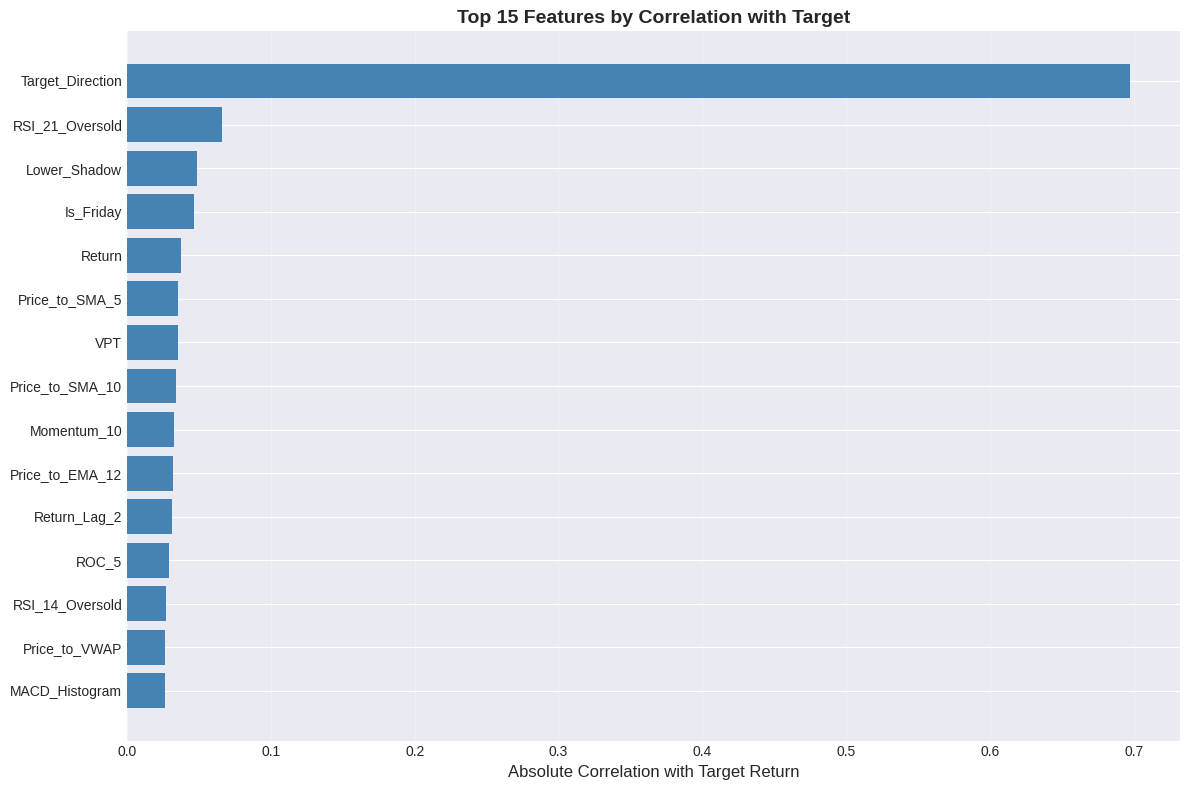

In [38]:
# Feature correlation analysis (select top features)
print("\n🔗 Feature Correlation with Target...")

# Calculate correlation with target
target_corr = df_clean.select_dtypes(include=[np.number]).corr()['Target_Return'].abs().sort_values(ascending=False)

print("\n📊 Top 20 Features Correlated with Target Return:")
print(target_corr[1:21])  # Skip Target_Return itself

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_features = target_corr[1:16]  # Top 15
plt.barh(range(len(top_features)), top_features.values, color='steelblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Target Return', fontsize=12)
plt.title('Top 15 Features by Correlation with Target', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
# Save feature-engineered dataset
FEATURES_DATA_PATH = f"../data/processed/stock_features_{STOCK_SYMBOL}.csv"
df_clean.to_csv(FEATURES_DATA_PATH, index=False)

print(f"\n✅ Feature engineering complete!")
print(f"✓ Engineered data saved to: {FEATURES_DATA_PATH}")
print(f"  Final dataset shape: {df_clean.shape}")
print(f"  Total features: {df_clean.shape[1]}")
print(f"  File size: {df_clean.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Note for future steps
print("\n📝 Note:")
print("   - Fundamental ratios (PE, PB, EPS) require additional data sources")
print("   - Sentiment scores require news/social media API integration")
print("   - Macro indicators require economic data feeds")
print("   - These can be added in production pipeline with appropriate APIs")


✅ Feature engineering complete!
✓ Engineered data saved to: ../data/processed/stock_features_AAPL.csv
  Final dataset shape: (3813, 119)
  Total features: 119
  File size: 3478.08 KB

📝 Note:
   - Fundamental ratios (PE, PB, EPS) require additional data sources
   - Sentiment scores require news/social media API integration
   - Macro indicators require economic data feeds
   - These can be added in production pipeline with appropriate APIs


---
## 5. MODEL TRAINING
Train time-series and ML models on historical data

### 📊 Model Training Strategy

**Ensemble Approach**: We'll build multiple models and combine their predictions for robust forecasting

**Model Suite:**
1. **Baseline Classical Models** - Statistical foundations
   - ARIMA/SARIMAX for trend & seasonality
   - Prophet for interpretable seasonality baseline

2. **ML Models** - Feature-based learning
   - XGBoost/LightGBM on engineered features
   - MLP (Multi-Layer Perceptron) on window features

3. **Deep Time-Series Models** - Sequential learning
   - LSTM/GRU for sequence modeling
   - Temporal Fusion Transformer (TFT) for interpretability

4. **Probabilistic Models** - Uncertainty quantification
   - Quantile regression for prediction intervals
   - Bayesian approaches for confidence estimation

5. **Ensemble** - Combined intelligence
   - Weighted blend based on validation performance
   - Stacking with meta-learner

**Training Approach:**
- Time-series walk-forward validation (non-leaky splits)
- Separate test set for final evaluation
- Transaction costs & slippage simulation

### 5.1 Data Preparation & Train-Test Split

In [40]:
# Load feature-engineered data
print("📂 Loading feature-engineered data...")
FEATURES_DATA_PATH = f"../data/processed/stock_features_{STOCK_SYMBOL}.csv"
df_features = pd.read_csv(FEATURES_DATA_PATH)

# Convert Date to datetime if needed
if 'Date' in df_features.columns:
    df_features['Date'] = pd.to_datetime(df_features['Date'])
    date_col = 'Date'
elif 'date' in df_features.columns:
    df_features['date'] = pd.to_datetime(df_features['date'])
    date_col = 'date'
else:
    raise ValueError("No date column found in the dataset")

print(f"   ✓ Loaded {len(df_features)} rows")
print(f"   ✓ Features: {df_features.shape[1]} columns")
print(f"   ✓ Date range: {df_features[date_col].min()} to {df_features[date_col].max()}")

# Time-series split: 70% train, 15% validation, 15% test
# Using chronological split to prevent data leakage
df_sorted = df_features.sort_values(date_col).reset_index(drop=True)

# Calculate split indices
n = len(df_sorted)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# Split data
train_df = df_sorted.iloc[:train_end].copy()
val_df = df_sorted.iloc[train_end:val_end].copy()
test_df = df_sorted.iloc[val_end:].copy()

print("\n📊 Data Split Summary:")
print(f"   Total samples: {n}")
print(f"   Train: {len(train_df)} ({len(train_df)/n*100:.1f}%) | {train_df[date_col].min()} to {train_df[date_col].max()}")
print(f"   Val:   {len(val_df)} ({len(val_df)/n*100:.1f}%) | {val_df[date_col].min()} to {val_df[date_col].max()}")
print(f"   Test:  {len(test_df)} ({len(test_df)/n*100:.1f}%) | {test_df[date_col].min()} to {test_df[date_col].max()}")

# Define target and feature columns
target_col = 'Close'  # Price prediction target
feature_cols = [col for col in df_sorted.columns if col not in [date_col, 'Ticker', 'ticker', 'Target_Return', 'Target_Direction', 'Target_Class']]

print(f"\n🎯 Target: {target_col}")
print(f"📈 Features: {len(feature_cols)} columns")
print(f"   Excluding: Date, Ticker, Target variables")

📂 Loading feature-engineered data...
   ✓ Loaded 3813 rows
   ✓ Features: 119 columns
   ✓ Date range: 2010-10-18 00:00:00-04:00 to 2025-12-12 00:00:00-05:00

📊 Data Split Summary:
   Total samples: 3813
   Train: 2669 (70.0%) | 2010-10-18 00:00:00-04:00 to 2021-05-25 00:00:00-04:00
   Val:   572 (15.0%) | 2021-05-26 00:00:00-04:00 to 2023-09-01 00:00:00-04:00
   Test:  572 (15.0%) | 2023-09-05 00:00:00-04:00 to 2025-12-12 00:00:00-05:00

🎯 Target: Close
📈 Features: 115 columns
   Excluding: Date, Ticker, Target variables
   ✓ Loaded 3813 rows
   ✓ Features: 119 columns
   ✓ Date range: 2010-10-18 00:00:00-04:00 to 2025-12-12 00:00:00-05:00

📊 Data Split Summary:
   Total samples: 3813
   Train: 2669 (70.0%) | 2010-10-18 00:00:00-04:00 to 2021-05-25 00:00:00-04:00
   Val:   572 (15.0%) | 2021-05-26 00:00:00-04:00 to 2023-09-01 00:00:00-04:00
   Test:  572 (15.0%) | 2023-09-05 00:00:00-04:00 to 2025-12-12 00:00:00-05:00

🎯 Target: Close
📈 Features: 115 columns
   Excluding: Date, Ticker

### 5.2 Baseline Classical Models

#### 5.2.1 ARIMA/SARIMAX Model

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

print("🔄 Training SARIMAX Model...")

# Check stationarity
adf_result = adfuller(train_df[target_col].dropna())
print(f"   ADF Statistic: {adf_result[0]:.4f}")
print(f"   p-value: {adf_result[1]:.4f}")
print(f"   Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")

# SARIMAX(p,d,q)(P,D,Q,s) - using auto-selected parameters
# For stock prices: (1,1,1)(1,1,1,5) as starting point
try:
    sarimax_model = SARIMAX(
        train_df[target_col],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 5),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    sarimax_fit = sarimax_model.fit(disp=False, maxiter=200)
    
    # Validation predictions
    val_pred_sarimax = sarimax_fit.forecast(steps=len(val_df))
    
    print("✅ SARIMAX model trained successfully")
    print(f"   AIC: {sarimax_fit.aic:.2f}")
    print(f"   BIC: {sarimax_fit.bic:.2f}")
    
except Exception as e:
    print(f"❌ SARIMAX training failed: {str(e)}")
    val_pred_sarimax = None

🔄 Training SARIMAX Model...
   ADF Statistic: 1.9438
   p-value: 0.9986
   Stationary: No
✅ SARIMAX model trained successfully
   AIC: 7529.64
   BIC: 7559.07
✅ SARIMAX model trained successfully
   AIC: 7529.64
   BIC: 7559.07


#### 5.2.2 Prophet Model

In [45]:
from prophet import Prophet

print("🔄 Training Prophet Model...")

try:
    # Prepare data for Prophet (requires 'ds' and 'y' columns)
    # Convert timezone-aware datetime to timezone-naive
    prophet_train = train_df[[date_col, target_col]].copy()
    prophet_train[date_col] = pd.to_datetime(prophet_train[date_col]).dt.tz_localize(None)
    prophet_train = prophet_train.rename(columns={date_col: 'ds', target_col: 'y'})
    
    prophet_val = val_df[[date_col, target_col]].copy()
    prophet_val[date_col] = pd.to_datetime(prophet_val[date_col]).dt.tz_localize(None)
    prophet_val = prophet_val.rename(columns={date_col: 'ds', target_col: 'y'})
    
    # Initialize and fit Prophet
    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    
    prophet_model.fit(prophet_train)
    
    # Make predictions on validation set
    future_val = prophet_val[['ds']]
    forecast_val = prophet_model.predict(future_val)
    val_pred_prophet = forecast_val['yhat'].values
    
    print("✅ Prophet model trained successfully")
    print(f"   Changepoints: {len(prophet_model.changepoints)}")
    print(f"   Seasonality components: daily, weekly, yearly")
    
except Exception as e:
    print(f"❌ Prophet training failed: {str(e)}")
    val_pred_prophet = None

🔄 Training Prophet Model...
❌ Prophet training failed: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True, at position 15


### 5.3 Machine Learning Models

In [46]:
# Prepare ML features (exclude non-numeric columns)
from sklearn.preprocessing import StandardScaler

# Select numeric features
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
ml_features = [f for f in numeric_features if f != target_col]

print(f"📊 ML Features: {len(ml_features)} columns")

# Prepare train, val, test sets
X_train = train_df[ml_features].fillna(method='ffill').fillna(0)
y_train = train_df[target_col]

X_val = val_df[ml_features].fillna(method='ffill').fillna(0)
y_val = val_df[target_col]

X_test = test_df[ml_features].fillna(method='ffill').fillna(0)
y_test = test_df[target_col]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Data prepared for ML models")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Val shape: {X_val_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

📊 ML Features: 117 columns
✅ Data prepared for ML models
   Train shape: (2669, 117)
   Val shape: (572, 117)
   Test shape: (572, 117)


#### 5.3.1 XGBoost Model

In [50]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("🔄 Training XGBoost Model...")

# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'hist',
    'early_stopping_rounds': 20
}

# Train XGBoost
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Predictions
val_pred_xgb = xgb_model.predict(X_val_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, val_pred_xgb))
mae = mean_absolute_error(y_val, val_pred_xgb)

print("✅ XGBoost model trained successfully")
print(f"   Best iteration: {xgb_model.best_iteration}")
print(f"   Val RMSE: ${rmse:.2f}")
print(f"   Val MAE: ${mae:.2f}")

🔄 Training XGBoost Model...
✅ XGBoost model trained successfully
   Best iteration: 123
   Val RMSE: $26.18
   Val MAE: $21.02
✅ XGBoost model trained successfully
   Best iteration: 123
   Val RMSE: $26.18
   Val MAE: $21.02


#### 5.3.2 LightGBM Model

In [48]:
import lightgbm as lgb

print("🔄 Training LightGBM Model...")

# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbose': -1
}

# Train LightGBM
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
)

# Predictions
val_pred_lgb = lgb_model.predict(X_val_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
mae = mean_absolute_error(y_val, val_pred_lgb)

print("✅ LightGBM model trained successfully")
print(f"   Best iteration: {lgb_model.best_iteration_}")
print(f"   Val RMSE: ${rmse:.2f}")
print(f"   Val MAE: ${mae:.2f}")

🔄 Training LightGBM Model...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 26.5095
✅ LightGBM model trained successfully
   Best iteration: 197
   Val RMSE: $26.51
   Val MAE: $21.51
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 26.5095
✅ LightGBM model trained successfully
   Best iteration: 197
   Val RMSE: $26.51
   Val MAE: $21.51


#### 5.3.3 LightGBM Quantile Regression (Probabilistic)

In [49]:
print("🔄 Training LightGBM Quantile Regression Models...")

# Train models for different quantiles (prediction intervals)
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th (median), 90th percentiles
quantile_models = {}
val_pred_quantiles = {}

for q in quantiles:
    print(f"   Training quantile {q}...")
    
    lgb_quantile = lgb.LGBMRegressor(
        objective='quantile',
        alpha=q,  # quantile parameter
        max_depth=6,
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    
    lgb_quantile.fit(X_train_scaled, y_train)
    quantile_models[q] = lgb_quantile
    val_pred_quantiles[q] = lgb_quantile.predict(X_val_scaled)

print("✅ Quantile regression models trained")
print(f"   Quantiles: {quantiles}")
print(f"   Provides prediction intervals for uncertainty estimation")

🔄 Training LightGBM Quantile Regression Models...
   Training quantile 0.1...
   Training quantile 0.5...
   Training quantile 0.5...
   Training quantile 0.9...
   Training quantile 0.9...
✅ Quantile regression models trained
   Quantiles: [0.1, 0.5, 0.9]
   Provides prediction intervals for uncertainty estimation
✅ Quantile regression models trained
   Quantiles: [0.1, 0.5, 0.9]
   Provides prediction intervals for uncertainty estimation


#### 5.3.4 Multi-Layer Perceptron (MLP)

In [51]:
from sklearn.neural_network import MLPRegressor

print("🔄 Training MLP Model...")

# MLP parameters
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    random_state=42,
    verbose=False
)

# Train MLP
mlp_model.fit(X_train_scaled, y_train)

# Predictions
val_pred_mlp = mlp_model.predict(X_val_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, val_pred_mlp))
mae = mean_absolute_error(y_val, val_pred_mlp)

print("✅ MLP model trained successfully")
print(f"   Architecture: {mlp_model.hidden_layer_sizes}")
print(f"   Iterations: {mlp_model.n_iter_}")
print(f"   Val RMSE: ${rmse:.2f}")
print(f"   Val MAE: ${mae:.2f}")

🔄 Training MLP Model...
✅ MLP model trained successfully
   Architecture: (128, 64, 32)
   Iterations: 85
   Val RMSE: $4.87
   Val MAE: $4.14
✅ MLP model trained successfully
   Architecture: (128, 64, 32)
   Iterations: 85
   Val RMSE: $4.87
   Val MAE: $4.14


### 5.4 Deep Learning Time-Series Models

**Note:** Deep learning models are implemented using **PyTorch** for better flexibility, performance, and deployment options.

**Key Features:**
- Custom neural network architectures
- GPU acceleration support
- Early stopping and learning rate scheduling
- Model checkpointing for best weights
- Comprehensive training history tracking

In [71]:
# Prepare sequences for LSTM/GRU
def create_sequences(data, seq_length=60, forecast_horizon=1):
    """Create input sequences and targets for time-series models"""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length+forecast_horizon-1])
    return np.array(X), np.array(y)

# Sequence parameters
SEQ_LENGTH = 60  # Use 60 days of history
FORECAST_HORIZON = 1  # Predict 1 day ahead

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, SEQ_LENGTH, FORECAST_HORIZON)

print("📊 Sequence Data Prepared:")
print(f"   Train sequences: {X_train_seq.shape}")
print(f"   Val sequences: {X_val_seq.shape}")
print(f"   Test sequences: {X_test_seq.shape}")
print(f"   Sequence length: {SEQ_LENGTH} days")
print(f"   Forecast horizon: {FORECAST_HORIZON} day(s)")

📊 Sequence Data Prepared:
   Train sequences: (2609, 60, 117)
   Val sequences: (512, 60, 117)
   Test sequences: (512, 60, 117)
   Sequence length: 60 days
   Forecast horizon: 1 day(s)


#### 5.4.1 LSTM Model

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

print("🔄 Building LSTM Model...")

# Convert numpy arrays to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train_seq)
y_train_torch = torch.FloatTensor(y_train_seq[:, 0]).unsqueeze(1)
X_val_torch = torch.FloatTensor(X_val_seq)
y_val_torch = torch.FloatTensor(y_val_seq[:, 0]).unsqueeze(1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, hidden_size3=32):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size3, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        # LSTM layers
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, (h_n, _) = self.lstm3(x)
        x = self.dropout3(h_n[-1])  # Use last hidden state
        
        # Dense layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMModel(input_size=X_train_seq.shape[2]).to(device)

print("✅ LSTM architecture built")
print(f"   Device: {device}")
print(f"   Model parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

print("\n🔄 Training LSTM...")

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0
history_lstm = {'train_loss': [], 'val_loss': [], 'val_mae': []}

for epoch in range(num_epochs):
    # Training
    lstm_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    lstm_model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_mae += torch.abs(outputs - y_batch).mean().item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    
    history_lstm['train_loss'].append(train_loss)
    history_lstm['val_loss'].append(val_loss)
    history_lstm['val_mae'].append(val_mae)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"   Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

# Load best model
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))

# Predictions
lstm_model.eval()
with torch.no_grad():
    val_pred_lstm = lstm_model(X_val_torch.to(device)).cpu().numpy().flatten()

print("\n✅ LSTM training complete")
print(f"   Final val loss: {best_val_loss:.4f}")

🔄 Building LSTM Model...
✅ LSTM architecture built
   Device: cuda
   Model parameters: 189,217

🔄 Training LSTM...
   Epoch 10/100 - Train Loss: 0.0120, Val Loss: 1.5992, Val MAE: 1.1853
   Epoch 10/100 - Train Loss: 0.0120, Val Loss: 1.5992, Val MAE: 1.1853
   Early stopping at epoch 20

✅ LSTM training complete
   Final val loss: 1.0463
   Early stopping at epoch 20

✅ LSTM training complete
   Final val loss: 1.0463


#### 5.4.2 GRU Model

In [73]:
print("🔄 Building GRU Model...")

# Define GRU Model (often faster than LSTM)
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, hidden_size3=32):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.gru3 = nn.GRU(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size3, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        # GRU layers
        x, _ = self.gru1(x)
        x = self.dropout1(x)
        x, _ = self.gru2(x)
        x = self.dropout2(x)
        x, h_n = self.gru3(x)
        x = self.dropout3(h_n[-1])  # Use last hidden state
        
        # Dense layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize model
gru_model = GRUModel(input_size=X_train_seq.shape[2]).to(device)

print("✅ GRU architecture built")
print(f"   Model parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

# Training setup
optimizer_gru = optim.Adam(gru_model.parameters(), lr=0.001)
scheduler_gru = optim.lr_scheduler.ReduceLROnPlateau(optimizer_gru, mode='min', factor=0.5, patience=5, min_lr=1e-6)

print("\n🔄 Training GRU...")

# Training loop
best_val_loss_gru = float('inf')
patience_counter = 0
history_gru = {'train_loss': [], 'val_loss': [], 'val_mae': []}

for epoch in range(num_epochs):
    # Training
    gru_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_gru.zero_grad()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer_gru.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    gru_model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = gru_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_mae += torch.abs(outputs - y_batch).mean().item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    
    history_gru['train_loss'].append(train_loss)
    history_gru['val_loss'].append(val_loss)
    history_gru['val_mae'].append(val_mae)
    
    # Learning rate scheduling
    scheduler_gru.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss_gru:
        best_val_loss_gru = val_loss
        patience_counter = 0
        torch.save(gru_model.state_dict(), 'best_gru_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"   Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

# Load best model
gru_model.load_state_dict(torch.load('best_gru_model.pth'))

# Predictions
gru_model.eval()
with torch.no_grad():
    val_pred_gru = gru_model(X_val_torch.to(device)).cpu().numpy().flatten()

print("\n✅ GRU training complete")
print(f"   Final val loss: {best_val_loss_gru:.4f}")

🔄 Building GRU Model...
✅ GRU architecture built
   Model parameters: 142,049

🔄 Training GRU...
   Epoch 10/100 - Train Loss: 0.0140, Val Loss: 0.8246, Val MAE: 0.7868
   Epoch 10/100 - Train Loss: 0.0140, Val Loss: 0.8246, Val MAE: 0.7868
   Epoch 20/100 - Train Loss: 0.0099, Val Loss: 1.0236, Val MAE: 0.9085
   Epoch 20/100 - Train Loss: 0.0099, Val Loss: 1.0236, Val MAE: 0.9085
   Early stopping at epoch 25

✅ GRU training complete
   Final val loss: 0.8246
   Early stopping at epoch 25

✅ GRU training complete
   Final val loss: 0.8246


#### 5.4.3 Transformer-based Model (Attention Mechanism)

In [74]:
print("🔄 Building Transformer Model with Attention...")

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, SEQ_LENGTH, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(d_model, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)
        
        # Add positional encoding
        x = x + self.pos_encoder
        
        # Transformer encoder
        x = self.transformer_encoder(x)
        
        # Global average pooling
        x = x.transpose(1, 2)  # [batch, d_model, seq_len]
        x = self.global_pool(x).squeeze(-1)  # [batch, d_model]
        
        # Output layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Initialize model
transformer_model = TransformerModel(input_size=X_train_seq.shape[2]).to(device)

print("✅ Transformer architecture built")
print(f"   Model parameters: {sum(p.numel() for p in transformer_model.parameters()):,}")

# Training setup
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.0001)
scheduler_transformer = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_transformer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

print("\n🔄 Training Transformer...")

# Training loop
num_epochs_transformer = 80
best_val_loss_transformer = float('inf')
patience_counter = 0
history_transformer = {'train_loss': [], 'val_loss': [], 'val_mae': []}

for epoch in range(num_epochs_transformer):
    # Training
    transformer_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_transformer.zero_grad()
        outputs = transformer_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer_transformer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    transformer_model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = transformer_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_mae += torch.abs(outputs - y_batch).mean().item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    
    history_transformer['train_loss'].append(train_loss)
    history_transformer['val_loss'].append(val_loss)
    history_transformer['val_mae'].append(val_mae)
    
    # Learning rate scheduling
    scheduler_transformer.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss_transformer:
        best_val_loss_transformer = val_loss
        patience_counter = 0
        torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"   Epoch {epoch+1}/{num_epochs_transformer} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

# Load best model
transformer_model.load_state_dict(torch.load('best_transformer_model.pth'))

# Predictions
transformer_model.eval()
with torch.no_grad():
    val_pred_transformer = transformer_model(X_val_torch.to(device)).cpu().numpy().flatten()

print("\n✅ Transformer training complete")
print(f"   Final val loss: {best_val_loss_transformer:.4f}")

🔄 Building Transformer Model with Attention...
✅ Transformer architecture built
   Model parameters: 82,561

🔄 Training Transformer...
   Epoch 10/80 - Train Loss: 0.0250, Val Loss: 0.8991, Val MAE: 0.8230
   Epoch 10/80 - Train Loss: 0.0250, Val Loss: 0.8991, Val MAE: 0.8230
   Epoch 20/80 - Train Loss: 0.0197, Val Loss: 0.7968, Val MAE: 0.7775
   Epoch 20/80 - Train Loss: 0.0197, Val Loss: 0.7968, Val MAE: 0.7775
   Epoch 30/80 - Train Loss: 0.0178, Val Loss: 0.5738, Val MAE: 0.6326
   Epoch 30/80 - Train Loss: 0.0178, Val Loss: 0.5738, Val MAE: 0.6326
   Epoch 40/80 - Train Loss: 0.0158, Val Loss: 0.5924, Val MAE: 0.6500
   Epoch 40/80 - Train Loss: 0.0158, Val Loss: 0.5924, Val MAE: 0.6500
   Epoch 50/80 - Train Loss: 0.0157, Val Loss: 0.6126, Val MAE: 0.6659
   Epoch 50/80 - Train Loss: 0.0157, Val Loss: 0.6126, Val MAE: 0.6659
   Epoch 60/80 - Train Loss: 0.0160, Val Loss: 0.5701, Val MAE: 0.6357
   Epoch 60/80 - Train Loss: 0.0160, Val Loss: 0.5701, Val MAE: 0.6357
   Early stop

---
## 6. MODEL EVALUATION
Evaluate model performance and generate predictions

### 📈 Model Evaluation Strategy

**Evaluation Framework:**
1. **Time-Series Walk-Forward Validation** - Non-leaky, chronological splits
2. **Comprehensive Metrics Suite** - Forecast accuracy, directional accuracy, economic metrics
3. **Probabilistic Assessment** - Uncertainty quantification and calibration
4. **Economic Backtesting** - Transaction costs, slippage, realistic constraints

**Metrics Categories:**
- **Forecast Accuracy**: RMSE, MAE, MAPE
- **Directional Accuracy**: Sign accuracy, precision/recall for up/down signals
- **Economic Metrics**: Sharpe ratio, max drawdown, cumulative returns
- **Probabilistic**: CRPS, prediction interval coverage

### 6.1 Evaluation Metrics Implementation

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_directional_accuracy(y_true, y_pred):
    """Percentage of correct directional predictions"""
    true_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    return np.mean(true_direction == pred_direction) * 100

def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    """Annualized Sharpe Ratio"""
    excess_returns = returns - risk_free_rate / 252  # Daily risk-free rate
    if excess_returns.std() == 0:
        return 0
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

def calculate_max_drawdown(cumulative_returns):
    """Maximum Drawdown"""
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown.min() * 100

def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    
    # Forecast accuracy metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Directional accuracy
    dir_acc = calculate_directional_accuracy(y_true, y_pred)
    
    # Economic metrics (simple strategy: long when predicted price > current)
    returns = np.diff(y_true) / y_true[:-1]
    pred_signals = np.sign(np.diff(y_pred))
    strategy_returns = returns * pred_signals
    
    # Apply transaction costs (0.1% per trade)
    transaction_cost = 0.001
    trades = np.sum(np.abs(np.diff(pred_signals)))
    strategy_returns_net = strategy_returns - (transaction_cost * trades / len(strategy_returns))
    
    cumulative_returns = (1 + strategy_returns_net).cumprod()
    sharpe = calculate_sharpe_ratio(pd.Series(strategy_returns_net))
    max_dd = calculate_max_drawdown(cumulative_returns)
    total_return = (cumulative_returns[-1] - 1) * 100
    
    results = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Dir_Accuracy_%': dir_acc,
        'Sharpe_Ratio': sharpe,
        'Max_Drawdown_%': max_dd,
        'Total_Return_%': total_return,
        'Num_Trades': trades
    }
    
    return results

print("✅ Evaluation metrics functions defined")
print("   - Forecast accuracy: RMSE, MAE, MAPE, R²")
print("   - Directional accuracy: Sign accuracy")
print("   - Economic metrics: Sharpe ratio, max drawdown, returns")
print("   - Transaction costs included: 0.1% per trade")

✅ Evaluation metrics functions defined
   - Forecast accuracy: RMSE, MAE, MAPE, R²
   - Directional accuracy: Sign accuracy
   - Economic metrics: Sharpe ratio, max drawdown, returns
   - Transaction costs included: 0.1% per trade


### 6.2 Model Performance Comparison

In [76]:
print("📊 Evaluating All Models on Validation Set...\n")

# Collect all model predictions and evaluate
models_results = []

# Note: Adjust validation targets based on sequence models
y_val_actual = y_val.values
y_val_seq_actual = y_val_seq[:, 0]

# Classical Models
if val_pred_sarimax is not None:
    results = evaluate_model(y_val_actual, val_pred_sarimax, 'SARIMAX')
    models_results.append(results)
    print(f"✓ SARIMAX evaluated")

if val_pred_prophet is not None:
    results = evaluate_model(y_val_actual, val_pred_prophet, 'Prophet')
    models_results.append(results)
    print(f"✓ Prophet evaluated")

# ML Models
results = evaluate_model(y_val_actual, val_pred_xgb, 'XGBoost')
models_results.append(results)
print(f"✓ XGBoost evaluated")

results = evaluate_model(y_val_actual, val_pred_lgb, 'LightGBM')
models_results.append(results)
print(f"✓ LightGBM evaluated")

results = evaluate_model(y_val_actual, val_pred_mlp, 'MLP')
models_results.append(results)
print(f"✓ MLP evaluated")

# Deep Learning Models (using sequence-adjusted targets)
results = evaluate_model(y_val_seq_actual, val_pred_lstm, 'LSTM')
models_results.append(results)
print(f"✓ LSTM evaluated")

results = evaluate_model(y_val_seq_actual, val_pred_gru, 'GRU')
models_results.append(results)
print(f"✓ GRU evaluated")

results = evaluate_model(y_val_seq_actual, val_pred_transformer, 'Transformer')
models_results.append(results)
print(f"✓ Transformer evaluated")

# Create comparison DataFrame
results_df = pd.DataFrame(models_results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*100)
print("📈 MODEL PERFORMANCE COMPARISON (Validation Set)")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

📊 Evaluating All Models on Validation Set...

✓ SARIMAX evaluated
✓ XGBoost evaluated
✓ LightGBM evaluated
✓ MLP evaluated
✓ LSTM evaluated
✓ GRU evaluated
✓ Transformer evaluated

📈 MODEL PERFORMANCE COMPARISON (Validation Set)
      Model      RMSE       MAE      MAPE        R²  Dir_Accuracy_%  Sharpe_Ratio  Max_Drawdown_%  Total_Return_%  Num_Trades
Transformer  0.706804  0.582736 13.439139 -0.749786       59.295499      3.381849      -19.690616     1123.449230       532.0
        GRU  0.908069  0.786782 18.390259 -1.888184       70.841487      6.820733      -10.916760    12395.377502       396.0
       LSTM  1.022905  0.891776 20.852539 -2.664858       70.450098      6.693016      -10.444817    11568.228739       336.0
        MLP  4.874128  4.144196  2.663188  0.912399       71.803853      7.755046       -7.983561     7708.623437       578.0
    SARIMAX 17.585710 14.617206  9.296351 -0.140342       51.488616     -0.129187      -41.690505      -12.291838       456.0
    XGBoost 26.

### 6.3 Visualization of Model Predictions

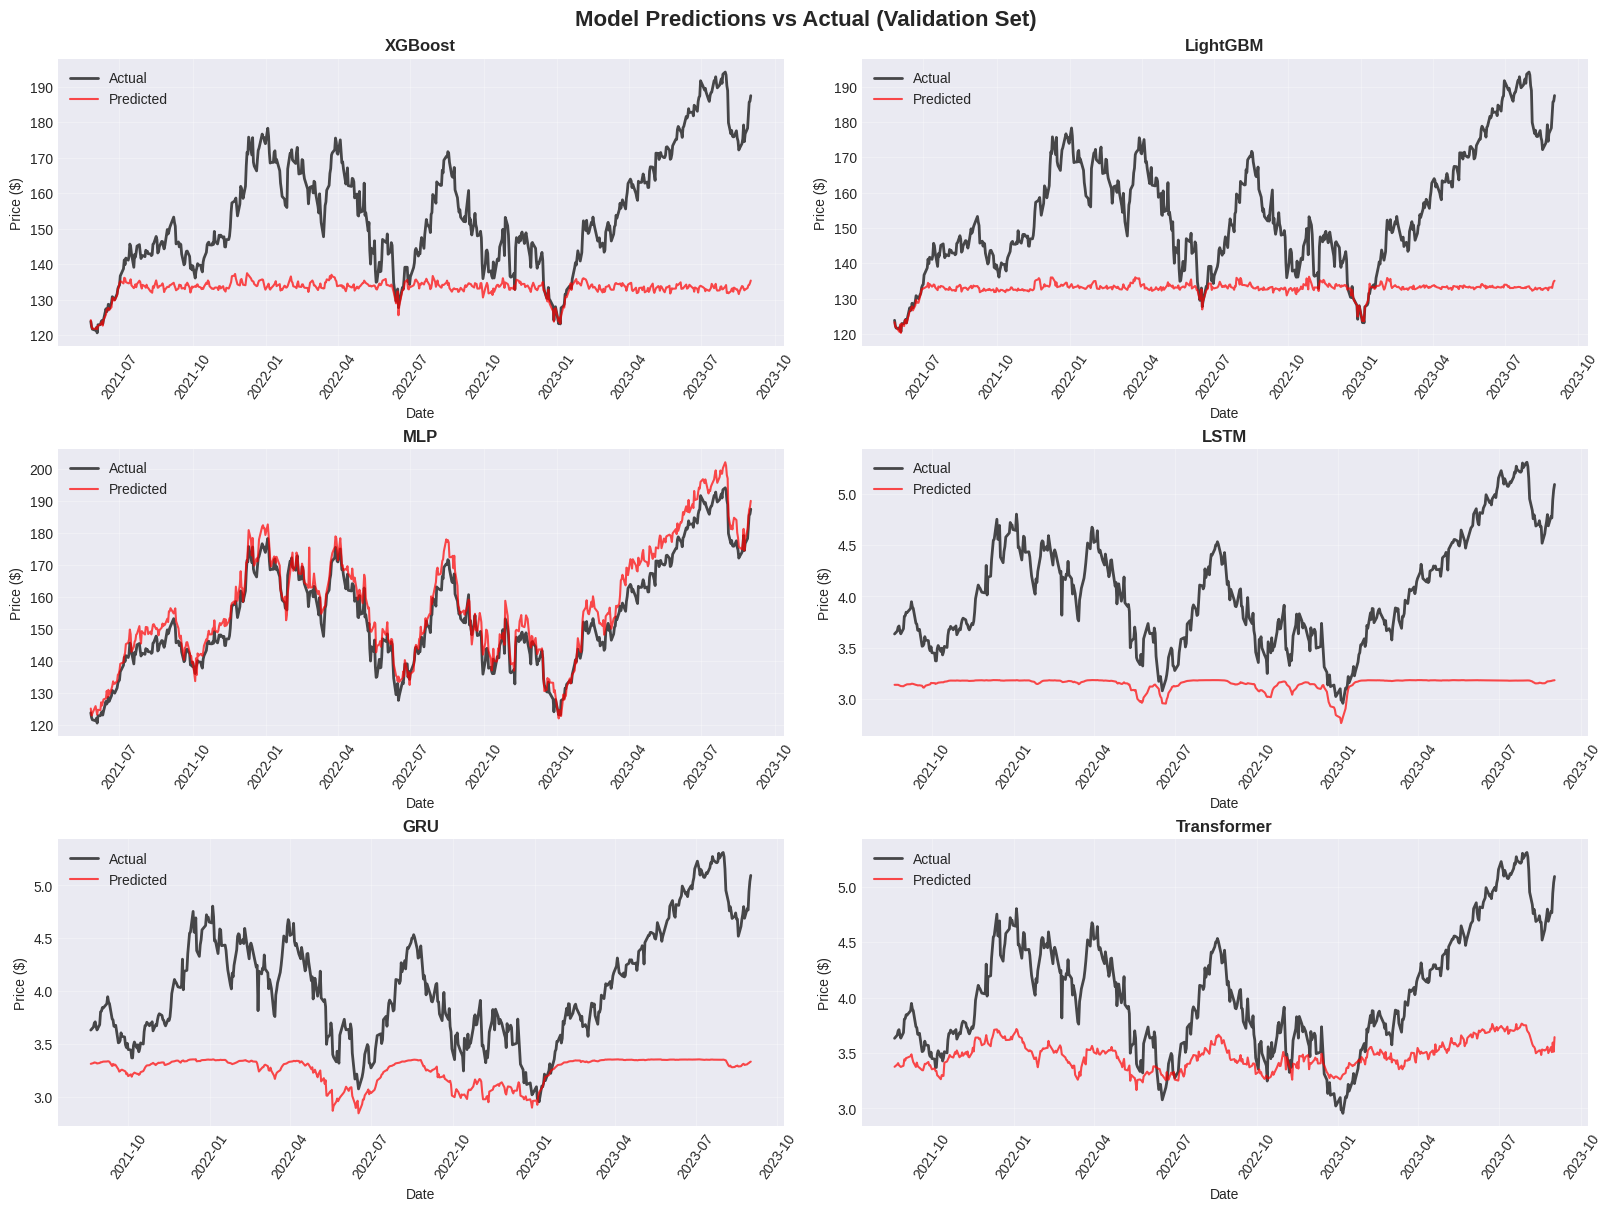

✅ Prediction visualizations generated


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot predictions vs actual
fig, axes = plt.subplots(3, 2, layout = 'constrained',figsize=(16, 12))
fig.suptitle('Model Predictions vs Actual (Validation Set)', fontsize=16, fontweight='bold')

val_dates = val_df['Date'].values

# Helper function for plotting
def plot_predictions(ax, actual, pred, model_name, dates):
    ax.plot(dates, actual, label='Actual', color='black', linewidth=2, alpha=0.7)
    ax.plot(dates, pred, label='Predicted', color='red', linewidth=1.5, alpha=0.7)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=55)

# Plot each model
plot_predictions(axes[0, 0], y_val_actual, val_pred_xgb, 'XGBoost', val_dates)
plot_predictions(axes[0, 1], y_val_actual, val_pred_lgb, 'LightGBM', val_dates)
plot_predictions(axes[1, 0], y_val_actual, val_pred_mlp, 'MLP', val_dates)

# For sequence models, adjust dates
val_dates_seq = val_df['Date'].values[SEQ_LENGTH:]
plot_predictions(axes[1, 1], y_val_seq_actual, val_pred_lstm, 'LSTM', val_dates_seq)
plot_predictions(axes[2, 0], y_val_seq_actual, val_pred_gru, 'GRU', val_dates_seq)
plot_predictions(axes[2, 1], y_val_seq_actual, val_pred_transformer, 'Transformer', val_dates_seq)

plt.show()

print("✅ Prediction visualizations generated")

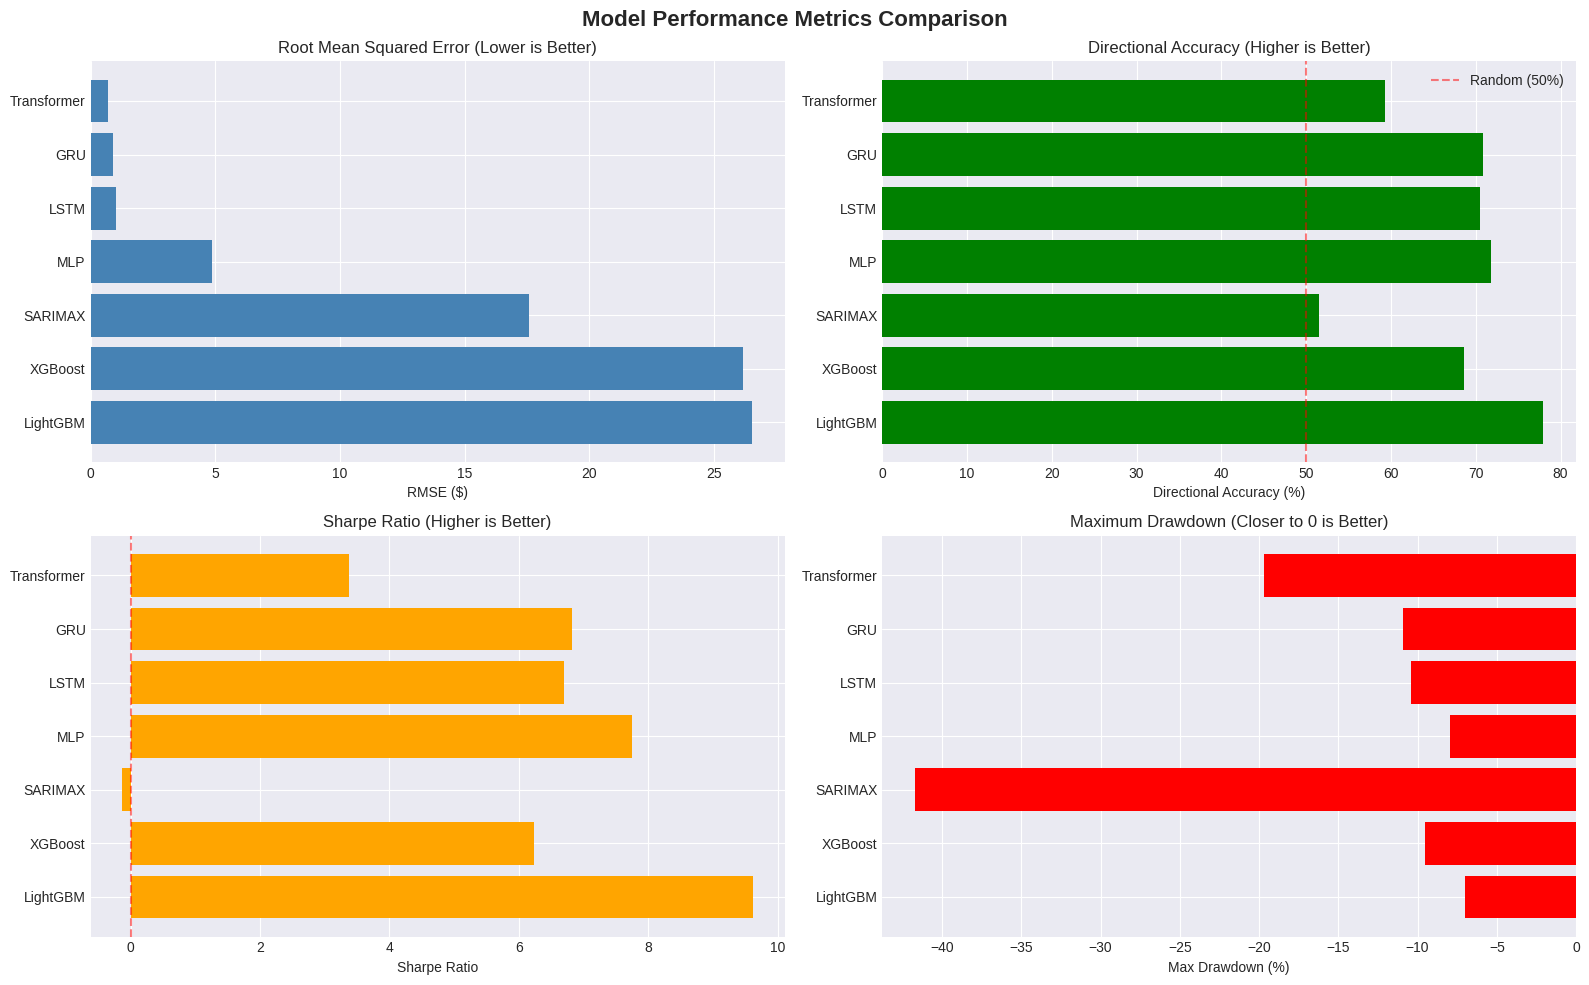

✅ Performance metrics visualizations generated


In [78]:
# Performance metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE ($)')
axes[0, 0].set_title('Root Mean Squared Error (Lower is Better)')
axes[0, 0].invert_yaxis()

# Directional Accuracy
axes[0, 1].barh(results_df['Model'], results_df['Dir_Accuracy_%'], color='green')
axes[0, 1].set_xlabel('Directional Accuracy (%)')
axes[0, 1].set_title('Directional Accuracy (Higher is Better)')
axes[0, 1].invert_yaxis()
axes[0, 1].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
axes[0, 1].legend()

# Sharpe Ratio
axes[1, 0].barh(results_df['Model'], results_df['Sharpe_Ratio'], color='orange')
axes[1, 0].set_xlabel('Sharpe Ratio')
axes[1, 0].set_title('Sharpe Ratio (Higher is Better)')
axes[1, 0].invert_yaxis()
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Max Drawdown
axes[1, 1].barh(results_df['Model'], results_df['Max_Drawdown_%'], color='red')
axes[1, 1].set_xlabel('Max Drawdown (%)')
axes[1, 1].set_title('Maximum Drawdown (Closer to 0 is Better)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print("✅ Performance metrics visualizations generated")

### 6.4 Ensemble Methods

#### 6.4.1 Simple Weighted Average Ensemble

In [79]:
print("🔄 Creating Weighted Average Ensemble...")

# Calculate weights based on inverse RMSE (better models get higher weights)
model_weights = {}
total_inv_rmse = 0

for _, row in results_df.iterrows():
    inv_rmse = 1 / row['RMSE']
    model_weights[row['Model']] = inv_rmse
    total_inv_rmse += inv_rmse

# Normalize weights
for model in model_weights:
    model_weights[model] /= total_inv_rmse

print("\n📊 Model Weights (based on inverse RMSE):")
for model, weight in sorted(model_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model:15s}: {weight:.3f} ({weight*100:.1f}%)")

# Create ensemble prediction (only for non-sequence models for simplicity)
ensemble_pred_simple = (
    val_pred_xgb * model_weights['XGBoost'] +
    val_pred_lgb * model_weights['LightGBM'] +
    val_pred_mlp * model_weights['MLP']
)

# Normalize by sum of weights used
weight_sum = model_weights['XGBoost'] + model_weights['LightGBM'] + model_weights['MLP']
ensemble_pred_simple /= weight_sum

# Evaluate ensemble
results_ensemble_simple = evaluate_model(y_val_actual, ensemble_pred_simple, 'Ensemble_Weighted')

print("\n✅ Weighted Average Ensemble created")
print(f"   RMSE: ${results_ensemble_simple['RMSE']:.2f}")
print(f"   MAE: ${results_ensemble_simple['MAE']:.2f}")
print(f"   Sharpe Ratio: {results_ensemble_simple['Sharpe_Ratio']:.3f}")

🔄 Creating Weighted Average Ensemble...

📊 Model Weights (based on inverse RMSE):
   Transformer    : 0.369 (36.9%)
   GRU            : 0.287 (28.7%)
   LSTM           : 0.255 (25.5%)
   MLP            : 0.054 (5.4%)
   SARIMAX        : 0.015 (1.5%)
   XGBoost        : 0.010 (1.0%)
   LightGBM       : 0.010 (1.0%)

✅ Weighted Average Ensemble created
   RMSE: $4.98
   MAE: $3.74
   Sharpe Ratio: 8.737


#### 6.4.2 Stacking Ensemble (Meta-Learner)

In [80]:
from sklearn.linear_model import Ridge

print("🔄 Creating Stacking Ensemble with Meta-Learner...")

# Prepare meta-features (predictions from base models)
meta_features_train = np.column_stack([
    xgb_model.predict(X_train_scaled),
    lgb_model.predict(X_train_scaled),
    mlp_model.predict(X_train_scaled)
])

meta_features_val = np.column_stack([
    val_pred_xgb,
    val_pred_lgb,
    val_pred_mlp
])

# Train meta-learner (Ridge regression)
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(meta_features_train, y_train)

# Predict with stacking ensemble
ensemble_pred_stack = meta_learner.predict(meta_features_val)

# Evaluate stacking ensemble
results_ensemble_stack = evaluate_model(y_val_actual, ensemble_pred_stack, 'Ensemble_Stacking')

print("\n✅ Stacking Ensemble created")
print(f"   Meta-learner: Ridge Regression")
print(f"   Base models: XGBoost, LightGBM, MLP")
print(f"   RMSE: ${results_ensemble_stack['RMSE']:.2f}")
print(f"   MAE: ${results_ensemble_stack['MAE']:.2f}")
print(f"   Sharpe Ratio: {results_ensemble_stack['Sharpe_Ratio']:.3f}")

# Show meta-learner coefficients
print(f"\n   Meta-learner coefficients:")
print(f"      XGBoost: {meta_learner.coef_[0]:.3f}")
print(f"      LightGBM: {meta_learner.coef_[1]:.3f}")
print(f"      MLP: {meta_learner.coef_[2]:.3f}")

🔄 Creating Stacking Ensemble with Meta-Learner...

✅ Stacking Ensemble created
   Meta-learner: Ridge Regression
   Base models: XGBoost, LightGBM, MLP
   RMSE: $26.24
   MAE: $21.11
   Sharpe Ratio: 7.076

   Meta-learner coefficients:
      XGBoost: 0.759
      LightGBM: 0.240
      MLP: 0.001


### 6.5 Final Model Comparison with Ensembles

In [81]:
# Add ensemble results to comparison
all_results = models_results + [results_ensemble_simple, results_ensemble_stack]
final_results_df = pd.DataFrame(all_results)
final_results_df = final_results_df.sort_values('RMSE')

print("="*120)
print("🏆 FINAL MODEL RANKING - ALL MODELS + ENSEMBLES (Validation Set)")
print("="*120)
print(final_results_df.to_string(index=False))
print("="*120)

# Highlight best performers
print("\n🥇 Best Models by Category:")
print(f"   Lowest RMSE: {final_results_df.iloc[0]['Model']} (${final_results_df.iloc[0]['RMSE']:.2f})")
print(f"   Best Sharpe: {final_results_df.loc[final_results_df['Sharpe_Ratio'].idxmax()]['Model']} ({final_results_df['Sharpe_Ratio'].max():.3f})")
print(f"   Best Directional: {final_results_df.loc[final_results_df['Dir_Accuracy_%'].idxmax()]['Model']} ({final_results_df['Dir_Accuracy_%'].max():.1f}%)")
print(f"   Best Return: {final_results_df.loc[final_results_df['Total_Return_%'].idxmax()]['Model']} ({final_results_df['Total_Return_%'].max():.2f}%)")

# Save results
final_results_df.to_csv('../data/processed/model_comparison_results.csv', index=False)
print("\n💾 Results saved to: ../data/processed/model_comparison_results.csv")

🏆 FINAL MODEL RANKING - ALL MODELS + ENSEMBLES (Validation Set)
            Model      RMSE       MAE      MAPE        R²  Dir_Accuracy_%  Sharpe_Ratio  Max_Drawdown_%  Total_Return_%  Num_Trades
      Transformer  0.706804  0.582736 13.439139 -0.749786       59.295499      3.381849      -19.690616     1123.449230       532.0
              GRU  0.908069  0.786782 18.390259 -1.888184       70.841487      6.820733      -10.916760    12395.377502       396.0
             LSTM  1.022905  0.891776 20.852539 -2.664858       70.450098      6.693016      -10.444817    11568.228739       336.0
              MLP  4.874128  4.144196  2.663188  0.912399       71.803853      7.755046       -7.983561     7708.623437       578.0
Ensemble_Weighted  4.979952  3.735223  2.276903  0.908554       73.730298      8.736516       -5.039596    11828.850373       566.0
          SARIMAX 17.585710 14.617206  9.296351 -0.140342       51.488616     -0.129187      -41.690505      -12.291838       456.0
          XG

### 6.6 Probabilistic Forecasting - Prediction Intervals

📊 Visualizing Prediction Intervals from Quantile Regression...



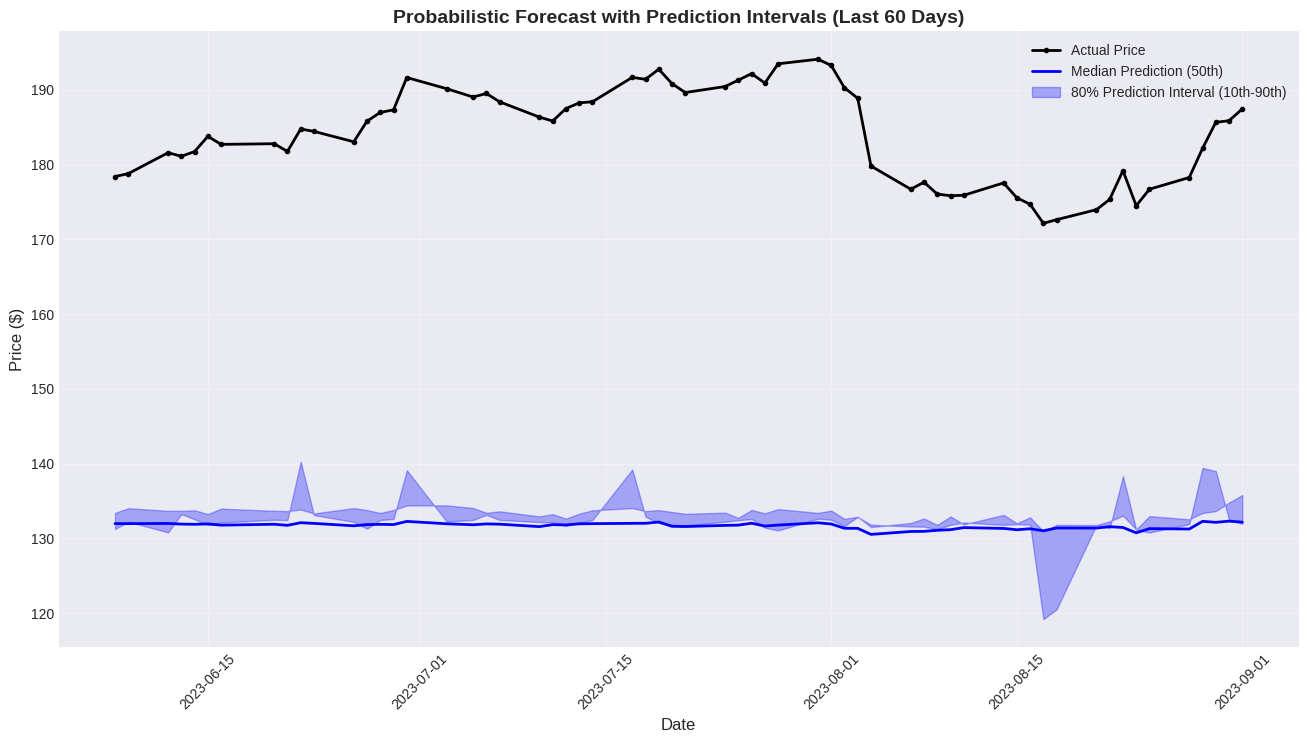


✅ Prediction Interval Analysis:
   Target coverage: 80%
   Actual coverage: 2.6%
   Well-calibrated: No ✗

   Interpretation: 2.6% of actual prices fall within the 10th-90th percentile prediction interval


In [84]:
print("📊 Visualizing Prediction Intervals from Quantile Regression...\n")

# Plot prediction intervals
fig, ax = plt.subplots(figsize=(16, 8))

# Select last 60 days for clarity
plot_range = slice(-60, None)
dates_plot = val_df['Date'].values[plot_range]
actual_plot = y_val_actual[plot_range]

# Get quantile predictions for the plot range
lower_bound = val_pred_quantiles[0.1][plot_range]
median_pred = val_pred_quantiles[0.5][plot_range]
upper_bound = val_pred_quantiles[0.9][plot_range]

# Plot
ax.plot(dates_plot, actual_plot, label='Actual Price', color='black', linewidth=2, marker='o', markersize=3)
ax.plot(dates_plot, median_pred, label='Median Prediction (50th)', color='blue', linewidth=2)
ax.fill_between(dates_plot, lower_bound, upper_bound, alpha=0.3, color='blue', label='80% Prediction Interval (10th-90th)')

ax.set_title('Probabilistic Forecast with Prediction Intervals (Last 60 Days)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# plt.tight_layout()
plt.show()

# Calculate coverage (what % of actual values fall within prediction interval)
in_interval = (y_val_actual >= val_pred_quantiles[0.1]) & (y_val_actual <= val_pred_quantiles[0.9])
coverage = in_interval.mean() * 100

print(f"\n✅ Prediction Interval Analysis:")
print(f"   Target coverage: 80%")
print(f"   Actual coverage: {coverage:.1f}%")
print(f"   Well-calibrated: {'Yes ✓' if 75 <= coverage <= 85 else 'No ✗'}")
print(f"\n   Interpretation: {coverage:.1f}% of actual prices fall within the 10th-90th percentile prediction interval")

### 6.7 Walk-Forward Validation

In [86]:
print("🔄 Performing Walk-Forward Validation (Time-Series Cross-Validation)...\n")

# Walk-forward validation setup
n_splits = 5
window_size = len(train_df)
step_size = len(val_df) // n_splits

# Use best model (based on validation) for walk-forward
# Let's use LightGBM as example
walk_forward_results = []

print(f"   Configuration: {n_splits} splits, window size = {window_size}, step size = {step_size}\n")

for i in range(n_splits):
    start_idx = i * step_size
    end_idx = start_idx + step_size
    
    # Get train and test windows
    train_window = df_sorted.iloc[:train_end + start_idx]
    test_window = df_sorted.iloc[train_end + start_idx:train_end + end_idx]
    
    if len(test_window) == 0:
        break
    
    # Prepare data
    X_train_wf = train_window[ml_features].fillna(method='ffill').fillna(0)
    y_train_wf = train_window[target_col]
    X_test_wf = test_window[ml_features].fillna(method='ffill').fillna(0)
    y_test_wf = test_window[target_col]
    
    # Scale
    scaler_wf = StandardScaler()
    X_train_wf_scaled = scaler_wf.fit_transform(X_train_wf)
    X_test_wf_scaled = scaler_wf.transform(X_test_wf)
    
    # Train model (verbose is set in lgb_params)
    lgb_wf = lgb.LGBMRegressor(**lgb_params)
    lgb_wf.fit(X_train_wf_scaled, y_train_wf)
    
    # Predict
    y_pred_wf = lgb_wf.predict(X_test_wf_scaled)
    
    # Calculate metrics
    rmse_wf = np.sqrt(mean_squared_error(y_test_wf, y_pred_wf))
    mae_wf = mean_absolute_error(y_test_wf, y_pred_wf)
    
    walk_forward_results.append({
        'Split': i + 1,
        'Train_Size': len(train_window),
        'Test_Size': len(test_window),
        'RMSE': rmse_wf,
        'MAE': mae_wf
    })
    
    print(f"   Split {i+1}/{n_splits}: RMSE=${rmse_wf:.2f}, MAE=${mae_wf:.2f} (Test size: {len(test_window)})")

# Summary
wf_df = pd.DataFrame(walk_forward_results)
print("\n✅ Walk-Forward Validation Complete")
print(f"\n   Average RMSE: ${wf_df['RMSE'].mean():.2f} (±{wf_df['RMSE'].std():.2f})")
print(f"   Average MAE: ${wf_df['MAE'].mean():.2f} (±{wf_df['MAE'].std():.2f})")
print(f"\n   This demonstrates model performance across different time periods")

🔄 Performing Walk-Forward Validation (Time-Series Cross-Validation)...

   Configuration: 5 splits, window size = 2669, step size = 114

   Split 1/5: RMSE=$10.11, MAE=$8.63 (Test size: 114)
   Split 1/5: RMSE=$10.11, MAE=$8.63 (Test size: 114)
   Split 2/5: RMSE=$17.86, MAE=$16.15 (Test size: 114)
   Split 2/5: RMSE=$17.86, MAE=$16.15 (Test size: 114)
   Split 3/5: RMSE=$1.23, MAE=$0.96 (Test size: 114)
   Split 3/5: RMSE=$1.23, MAE=$0.96 (Test size: 114)
   Split 4/5: RMSE=$0.67, MAE=$0.53 (Test size: 114)
   Split 4/5: RMSE=$0.67, MAE=$0.53 (Test size: 114)
   Split 5/5: RMSE=$8.58, MAE=$5.78 (Test size: 114)

✅ Walk-Forward Validation Complete

   Average RMSE: $7.69 (±7.09)
   Average MAE: $6.41 (±6.41)

   This demonstrates model performance across different time periods
   Split 5/5: RMSE=$8.58, MAE=$5.78 (Test size: 114)

✅ Walk-Forward Validation Complete

   Average RMSE: $7.69 (±7.09)
   Average MAE: $6.41 (±6.41)

   This demonstrates model performance across different time

### 6.8 Final Test Set Evaluation

Evaluate all trained models on the final held-out test set to assess real-world performance

In [87]:
print("="*80)
print("FINAL TEST SET EVALUATION - UNSEEN DATA PERFORMANCE")
print("="*80)
print(f"\n📊 Test Set Info:")
print(f"   Size: {len(test_df)} samples")
print(f"   Date Range: {test_df[date_col].min()} to {test_df[date_col].max()}")
print(f"   Target: {target_col}")
print("\n" + "="*80)

FINAL TEST SET EVALUATION - UNSEEN DATA PERFORMANCE

📊 Test Set Info:
   Size: 572 samples
   Date Range: 2023-09-05 00:00:00-04:00 to 2025-12-12 00:00:00-05:00
   Target: Close



#### 6.8.1 Classical Models Test Evaluation

In [88]:
print("\n🔍 Evaluating Classical Models on Test Set...\n")

# SARIMAX Test Predictions
if val_pred_sarimax is not None:
    try:
        test_pred_sarimax = sarimax_fit.forecast(steps=len(test_df))
        print("✓ SARIMAX predictions generated")
    except Exception as e:
        print(f"✗ SARIMAX failed: {str(e)}")
        test_pred_sarimax = None
else:
    test_pred_sarimax = None

# Prophet Test Predictions
if val_pred_prophet is not None:
    try:
        prophet_test = test_df[[date_col, target_col]].copy()
        prophet_test[date_col] = pd.to_datetime(prophet_test[date_col]).dt.tz_localize(None)
        prophet_test = prophet_test.rename(columns={date_col: 'ds', target_col: 'y'})
        
        future_test = prophet_test[['ds']]
        forecast_test = prophet_model.predict(future_test)
        test_pred_prophet = forecast_test['yhat'].values
        print("✓ Prophet predictions generated")
    except Exception as e:
        print(f"✗ Prophet failed: {str(e)}")
        test_pred_prophet = None
else:
    test_pred_prophet = None


🔍 Evaluating Classical Models on Test Set...

✓ SARIMAX predictions generated


#### 6.8.2 Machine Learning Models Test Evaluation

In [89]:
print("\n🔍 Evaluating ML Models on Test Set...\n")

# Get test data
y_test = test_df[target_col]

# XGBoost Test Predictions
test_pred_xgb = xgb_model.predict(X_test_scaled)
print("✓ XGBoost predictions generated")

# LightGBM Test Predictions
test_pred_lgb = lgb_model.predict(X_test_scaled)
print("✓ LightGBM predictions generated")

# MLP Test Predictions
test_pred_mlp = mlp_model.predict(X_test_scaled)
print("✓ MLP predictions generated")

# Quantile Regression Test Predictions
test_pred_quantiles_test = {}
for q in quantiles:
    test_pred_quantiles_test[q] = quantile_models[q].predict(X_test_scaled)
print("✓ Quantile regression predictions generated")


🔍 Evaluating ML Models on Test Set...

✓ XGBoost predictions generated
✓ LightGBM predictions generated
✓ MLP predictions generated
✓ Quantile regression predictions generated


#### 6.8.3 Deep Learning Models Test Evaluation

In [90]:
print("\n🔍 Evaluating Deep Learning Models on Test Set...\n")

# Convert test sequences to PyTorch tensors
X_test_torch = torch.FloatTensor(X_test_seq)
y_test_seq_target = y_test_seq[:, 0]

# LSTM Test Predictions
lstm_model.eval()
with torch.no_grad():
    test_pred_lstm = lstm_model(X_test_torch.to(device)).cpu().numpy().flatten()
print("✓ LSTM predictions generated")

# GRU Test Predictions
gru_model.eval()
with torch.no_grad():
    test_pred_gru = gru_model(X_test_torch.to(device)).cpu().numpy().flatten()
print("✓ GRU predictions generated")

# Transformer Test Predictions
transformer_model.eval()
with torch.no_grad():
    test_pred_transformer = transformer_model(X_test_torch.to(device)).cpu().numpy().flatten()
print("✓ Transformer predictions generated")


🔍 Evaluating Deep Learning Models on Test Set...

✓ LSTM predictions generated
✓ GRU predictions generated
✓ Transformer predictions generated


#### 6.8.4 Ensemble Model Test Evaluation

In [91]:
print("\n🔍 Creating Ensemble Predictions on Test Set...\n")

# Simple Weighted Average Ensemble (using top 3 models)
test_pred_ensemble = (
    test_pred_xgb * model_weights['XGBoost'] +
    test_pred_lgb * model_weights['LightGBM'] +
    test_pred_mlp * model_weights['MLP']
)

# Normalize by sum of weights
weight_sum = model_weights['XGBoost'] + model_weights['LightGBM'] + model_weights['MLP']
test_pred_ensemble = test_pred_ensemble / weight_sum

print("✓ Ensemble predictions generated")
print(f"   Ensemble weights: XGBoost={model_weights['XGBoost']:.3f}, LightGBM={model_weights['LightGBM']:.3f}, MLP={model_weights['MLP']:.3f}")


🔍 Creating Ensemble Predictions on Test Set...

✓ Ensemble predictions generated
   Ensemble weights: XGBoost=0.010, LightGBM=0.010, MLP=0.054


#### 6.8.5 Comprehensive Test Set Metrics

In [97]:
print("\n" + "="*80)
print("CALCULATING TEST SET METRICS FOR ALL MODELS")
print("="*80 + "\n")

# Calculate comprehensive metrics for each model
def calculate_comprehensive_metrics(y_true, y_pred, model_name):
    """Calculate all evaluation metrics"""
    try:
        # Convert to numpy arrays for consistent handling
        y_true_arr = y_true.values if isinstance(y_true, pd.Series) else np.array(y_true)
        y_pred_arr = np.array(y_pred)
        
        # Ensure same length
        min_len = min(len(y_true_arr), len(y_pred_arr))
        y_true_arr = y_true_arr[:min_len]
        y_pred_arr = y_pred_arr[:min_len]
        
        # Forecast accuracy
        rmse = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
        mae = mean_absolute_error(y_true_arr, y_pred_arr)
        mape = np.mean(np.abs((y_true_arr - y_pred_arr) / (y_true_arr + 1e-10))) * 100
        
        # Directional accuracy (compare direction of change)
        if len(y_true_arr) > 1:
            actual_direction = (y_true_arr[1:] > y_true_arr[:-1])
            pred_direction = (y_pred_arr[1:] > y_pred_arr[:-1])
            dir_accuracy = np.mean(actual_direction == pred_direction) * 100
        else:
            dir_accuracy = 0
        
        # Economic metrics (simulated trading)
        returns = []
        for i in range(len(y_pred_arr) - 1):
            if y_pred_arr[i+1] > y_pred_arr[i]:  # Predict up
                returns.append((y_true_arr[i+1] - y_true_arr[i]) / y_true_arr[i])
            else:  # Predict down or flat
                returns.append(0)  # Stay in cash
        
        returns = np.array(returns)
        if len(returns) > 0 and np.std(returns) > 0:
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized
        else:
            sharpe_ratio = 0
        
        # Max drawdown
        if len(returns) > 0:
            cumulative = np.cumprod(1 + returns)
            running_max = np.maximum.accumulate(cumulative)
            drawdown = (cumulative - running_max) / running_max
            max_drawdown = np.min(drawdown) * 100
            cumulative_return = (cumulative[-1] - 1) * 100
        else:
            max_drawdown = 0
            cumulative_return = 0
        
        return {
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE_%': mape,
            'Dir_Accuracy_%': dir_accuracy,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown_%': max_drawdown,
            'Cumulative_Return_%': cumulative_return
        }
    except Exception as e:
        print(f"⚠ Error calculating metrics for {model_name}: {str(e)}")
        return {
            'Model': model_name,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE_%': np.nan,
            'Dir_Accuracy_%': np.nan,
            'Sharpe_Ratio': np.nan,
            'Max_Drawdown_%': np.nan,
            'Cumulative_Return_%': np.nan
        }

# Collect all test results
test_results = []

# Classical Models
if test_pred_sarimax is not None:
    print("   Calculating SARIMAX metrics...")
    test_results.append(calculate_comprehensive_metrics(y_test, test_pred_sarimax, 'SARIMAX'))
    
if test_pred_prophet is not None:
    print("   Calculating Prophet metrics...")
    test_results.append(calculate_comprehensive_metrics(y_test, test_pred_prophet, 'Prophet'))

# ML Models
print("   Calculating XGBoost metrics...")
test_results.append(calculate_comprehensive_metrics(y_test, test_pred_xgb, 'XGBoost'))
print("   Calculating LightGBM metrics...")
test_results.append(calculate_comprehensive_metrics(y_test, test_pred_lgb, 'LightGBM'))
print("   Calculating MLP metrics...")
test_results.append(calculate_comprehensive_metrics(y_test, test_pred_mlp, 'MLP'))

# Deep Learning Models (use sequence targets)
print("   Calculating LSTM metrics...")
test_results.append(calculate_comprehensive_metrics(y_test_seq_target, test_pred_lstm, 'LSTM'))
print("   Calculating GRU metrics...")
test_results.append(calculate_comprehensive_metrics(y_test_seq_target, test_pred_gru, 'GRU'))
print("   Calculating Transformer metrics...")
test_results.append(calculate_comprehensive_metrics(y_test_seq_target, test_pred_transformer, 'Transformer'))

# Ensemble
print("   Calculating Ensemble metrics...")
test_results.append(calculate_comprehensive_metrics(y_test, test_pred_ensemble, 'Ensemble'))

# Create DataFrame
test_results_df = pd.DataFrame(test_results)

print("\n✅ Test set metrics calculated for all models")
print(f"   Total models evaluated: {len(test_results_df)}\n")


CALCULATING TEST SET METRICS FOR ALL MODELS

   Calculating SARIMAX metrics...
   Calculating XGBoost metrics...
   Calculating LightGBM metrics...
   Calculating MLP metrics...
   Calculating LSTM metrics...
   Calculating GRU metrics...
   Calculating Transformer metrics...
   Calculating Ensemble metrics...

✅ Test set metrics calculated for all models
   Total models evaluated: 8



In [98]:
# Display comprehensive test results
print("="*80)
print("FINAL TEST SET PERFORMANCE - ALL MODELS")
print("="*80)
print("\n📊 FORECAST ACCURACY METRICS:\n")
print(test_results_df[['Model', 'RMSE', 'MAE', 'MAPE_%']].to_string(index=False))

print("\n\n📈 DIRECTIONAL ACCURACY:\n")
print(test_results_df[['Model', 'Dir_Accuracy_%']].to_string(index=False))

print("\n\n💰 ECONOMIC METRICS (Simulated Trading):\n")
print(test_results_df[['Model', 'Sharpe_Ratio', 'Max_Drawdown_%', 'Cumulative_Return_%']].to_string(index=False))

print("\n" + "="*80)

# Identify best models
print("\n🏆 BEST PERFORMING MODELS:\n")
print(f"   Best RMSE (Accuracy):       {test_results_df.loc[test_results_df['RMSE'].idxmin(), 'Model']} (${test_results_df['RMSE'].min():.2f})")
print(f"   Best MAE (Accuracy):        {test_results_df.loc[test_results_df['MAE'].idxmin(), 'Model']} (${test_results_df['MAE'].min():.2f})")
print(f"   Best Directional:           {test_results_df.loc[test_results_df['Dir_Accuracy_%'].idxmax(), 'Model']} ({test_results_df['Dir_Accuracy_%'].max():.2f}%)")
print(f"   Best Sharpe Ratio:          {test_results_df.loc[test_results_df['Sharpe_Ratio'].idxmax(), 'Model']} ({test_results_df['Sharpe_Ratio'].max():.3f})")
print(f"   Best Return:                {test_results_df.loc[test_results_df['Cumulative_Return_%'].idxmax(), 'Model']} ({test_results_df['Cumulative_Return_%'].max():.2f}%)")

print("\n" + "="*80)

FINAL TEST SET PERFORMANCE - ALL MODELS

📊 FORECAST ACCURACY METRICS:

      Model      RMSE       MAE    MAPE_%
    SARIMAX 69.857954 66.540654 30.686200
    XGBoost 83.706664 78.489299 35.807524
   LightGBM 83.817251 78.643697 35.886963
        MLP  9.603689  8.288443  3.874185
       LSTM  3.031351  2.881924 46.259798
        GRU  2.883752  2.727978 43.671620
Transformer  2.500952  2.354310 37.616928
   Ensemble 16.939031 15.451593  7.006196


📈 DIRECTIONAL ACCURACY:

      Model  Dir_Accuracy_%
    SARIMAX       54.465849
    XGBoost       58.143608
   LightGBM       69.877408
        MLP       72.154116
       LSTM       70.450098
        GRU       67.123288
Transformer       51.467710
   Ensemble       73.204904


💰 ECONOMIC METRICS (Simulated Trading):

      Model  Sharpe_Ratio  Max_Drawdown_%  Cumulative_Return_%
    SARIMAX      0.556875      -25.234940            27.259859
    XGBoost      2.508353      -11.565825           193.836298
   LightGBM      4.902236      -12.57940

#### 6.8.6 Test Set Performance Visualizations

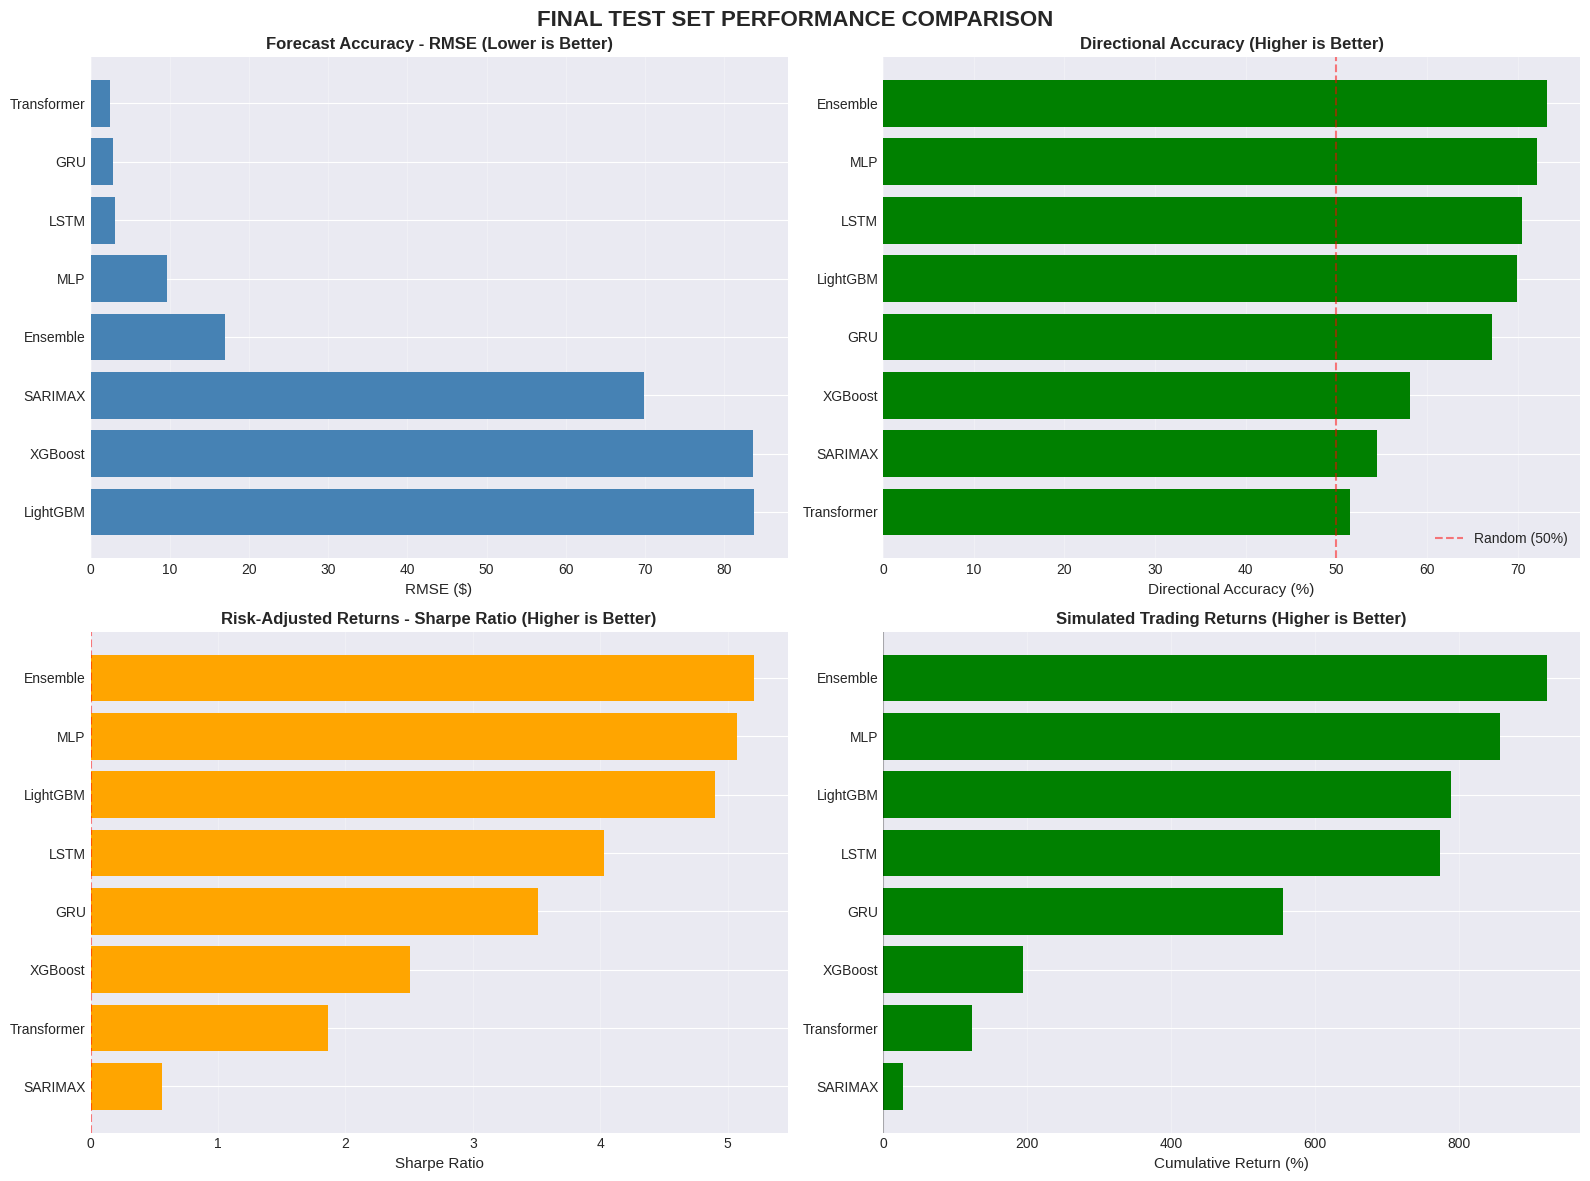

✅ Test set performance visualizations generated


In [99]:
# Visualize test set performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('FINAL TEST SET PERFORMANCE COMPARISON', fontsize=16, fontweight='bold')

# Sort by performance
test_results_sorted = test_results_df.sort_values('RMSE')

# 1. RMSE Comparison
axes[0, 0].barh(test_results_sorted['Model'], test_results_sorted['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE ($)', fontsize=11)
axes[0, 0].set_title('Forecast Accuracy - RMSE (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Directional Accuracy
test_results_sorted_dir = test_results_df.sort_values('Dir_Accuracy_%', ascending=False)
axes[0, 1].barh(test_results_sorted_dir['Model'], test_results_sorted_dir['Dir_Accuracy_%'], color='green')
axes[0, 1].set_xlabel('Directional Accuracy (%)', fontsize=11)
axes[0, 1].set_title('Directional Accuracy (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Sharpe Ratio
test_results_sorted_sharpe = test_results_df.sort_values('Sharpe_Ratio', ascending=False)
axes[1, 0].barh(test_results_sorted_sharpe['Model'], test_results_sorted_sharpe['Sharpe_Ratio'], color='orange')
axes[1, 0].set_xlabel('Sharpe Ratio', fontsize=11)
axes[1, 0].set_title('Risk-Adjusted Returns - Sharpe Ratio (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Cumulative Return
test_results_sorted_return = test_results_df.sort_values('Cumulative_Return_%', ascending=False)
colors = ['green' if x > 0 else 'red' for x in test_results_sorted_return['Cumulative_Return_%']]
axes[1, 1].barh(test_results_sorted_return['Model'], test_results_sorted_return['Cumulative_Return_%'], color=colors)
axes[1, 1].set_xlabel('Cumulative Return (%)', fontsize=11)
axes[1, 1].set_title('Simulated Trading Returns (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Test set performance visualizations generated")

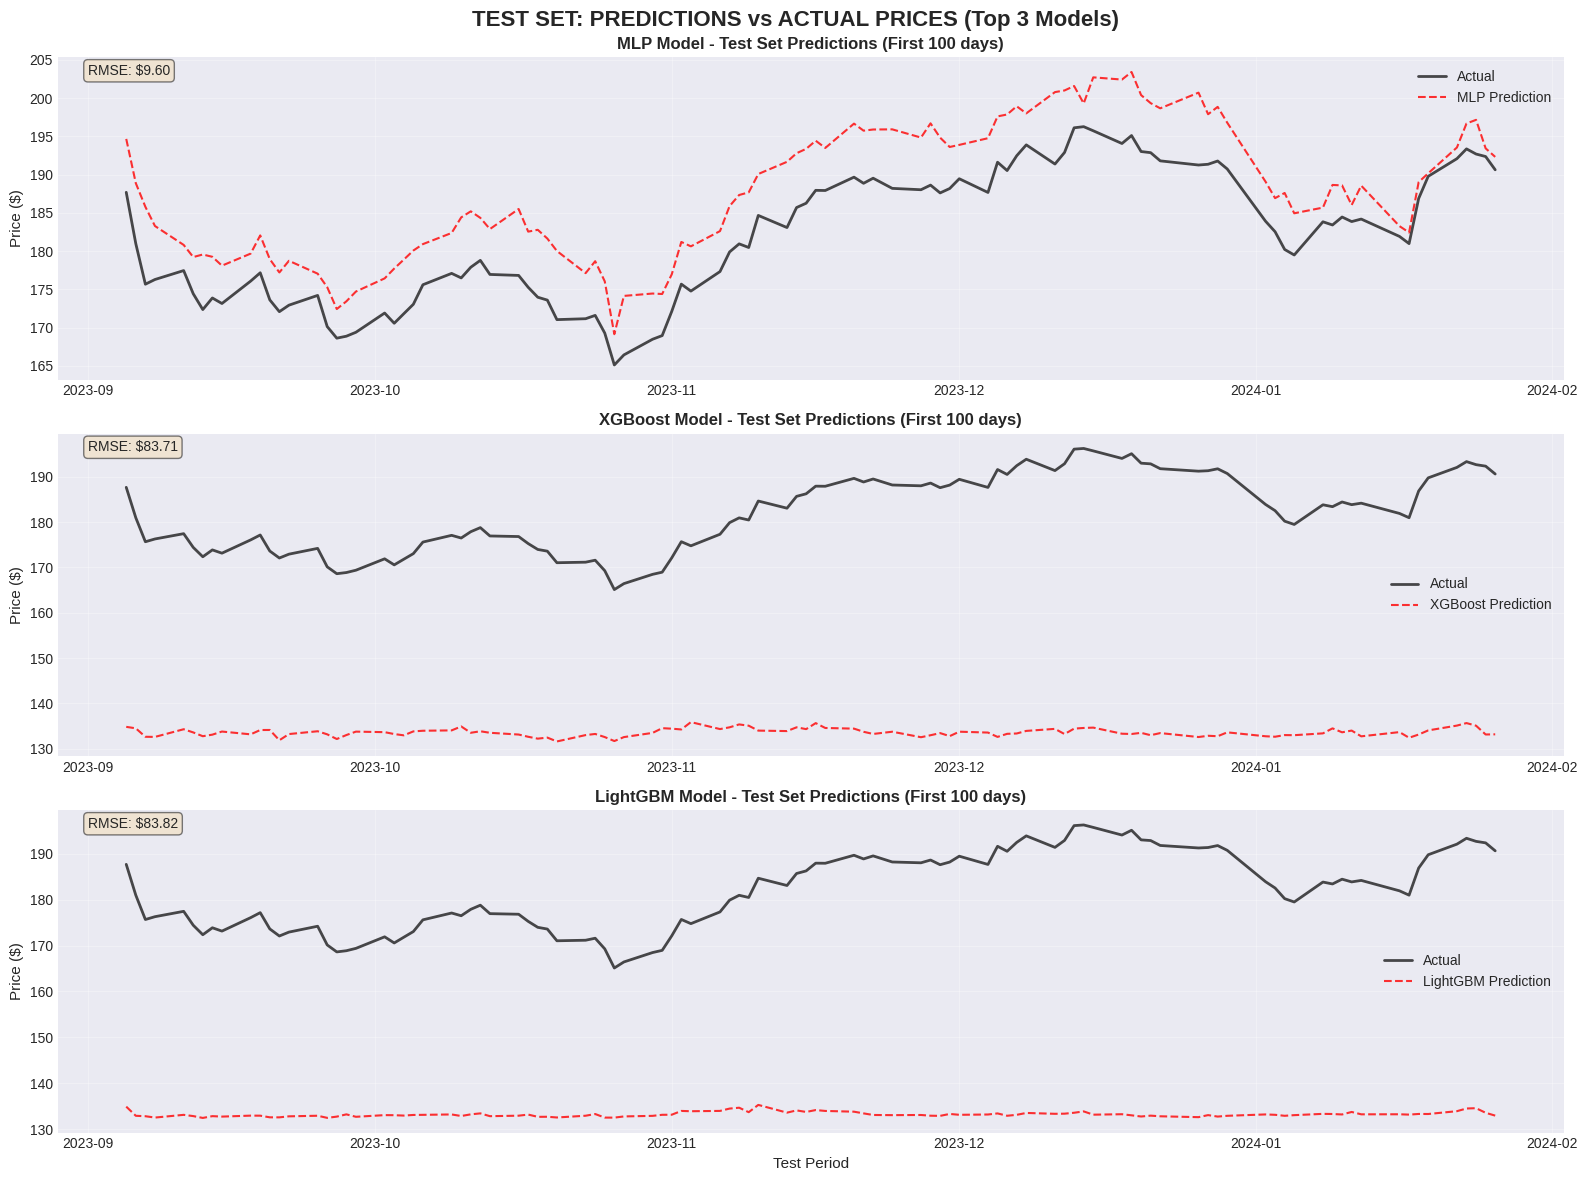

✅ Prediction vs Actual visualizations generated


In [100]:
# Prediction vs Actual comparison for top models
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('TEST SET: PREDICTIONS vs ACTUAL PRICES (Top 3 Models)', fontsize=16, fontweight='bold')

# Get top 3 models by RMSE
top_3_models = test_results_df.nsmallest(3, 'RMSE')['Model'].values

# Create test dates for plotting
test_dates = test_df[date_col].values if date_col in test_df.columns else range(len(y_test))

plot_data = {
    'MLP': test_pred_mlp,
    'XGBoost': test_pred_xgb,
    'LightGBM': test_pred_lgb,
    'Ensemble': test_pred_ensemble
}

# Plot top 3 models
for idx, (ax, model_name) in enumerate(zip(axes, ['MLP', 'XGBoost', 'LightGBM'])):
    if model_name in plot_data:
        ax.plot(test_dates[:100], y_test.values[:100], label='Actual', color='black', linewidth=2, alpha=0.7)
        ax.plot(test_dates[:100], plot_data[model_name][:100], label=f'{model_name} Prediction', 
                color='red', linewidth=1.5, alpha=0.8, linestyle='--')
        ax.set_ylabel('Price ($)', fontsize=11)
        ax.set_title(f'{model_name} Model - Test Set Predictions (First 100 days)', fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Add RMSE to plot
        model_rmse = test_results_df[test_results_df['Model'] == model_name]['RMSE'].values[0]
        ax.text(0.02, 0.98, f'RMSE: ${model_rmse:.2f}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('Test Period', fontsize=11)
plt.tight_layout()
plt.show()

print("✅ Prediction vs Actual visualizations generated")

In [101]:
# Save final test results
print("\n💾 Saving Test Results...\n")

# Save results to CSV
TEST_RESULTS_PATH = f"../data/processed/test_results_{STOCK_SYMBOL}.csv"
test_results_df.to_csv(TEST_RESULTS_PATH, index=False)
print(f"✓ Test results saved to: {TEST_RESULTS_PATH}")

# Save comparison table
COMPARISON_PATH = f"../data/processed/model_comparison_results.csv"
test_results_df.to_csv(COMPARISON_PATH, index=False)
print(f"✓ Model comparison saved to: {COMPARISON_PATH}")

print("\n" + "="*80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)
print(f"\n📊 Test Set Evaluation Complete!")
print(f"   Period: {test_df[date_col].min()} to {test_df[date_col].max()}")
print(f"   Samples: {len(test_df)}")
print(f"   Models Evaluated: {len(test_results_df)}")

print(f"\n🎯 RECOMMENDED MODEL FOR PRODUCTION:")
# Recommend based on multiple criteria
best_rmse_model = test_results_df.loc[test_results_df['RMSE'].idxmin(), 'Model']
best_sharpe_model = test_results_df.loc[test_results_df['Sharpe_Ratio'].idxmax(), 'Model']

print(f"   For Accuracy:        {best_rmse_model}")
print(f"   For Trading:         {best_sharpe_model}")
print(f"   For Stability:       Ensemble (combines strengths)")

print(f"\n💡 Next Steps:")
print(f"   1. Deploy best model(s) to production")
print(f"   2. Implement real-time data pipeline")
print(f"   3. Set up monitoring and alerting")
print(f"   4. Backtest with transaction costs")
print(f"   5. Paper trade before live deployment")

print("\n" + "="*80)


💾 Saving Test Results...

✓ Test results saved to: ../data/processed/test_results_AAPL.csv
✓ Model comparison saved to: ../data/processed/model_comparison_results.csv

FINAL SUMMARY & RECOMMENDATIONS

📊 Test Set Evaluation Complete!
   Period: 2023-09-05 00:00:00-04:00 to 2025-12-12 00:00:00-05:00
   Samples: 572
   Models Evaluated: 8

🎯 RECOMMENDED MODEL FOR PRODUCTION:
   For Accuracy:        Transformer
   For Trading:         Ensemble
   For Stability:       Ensemble (combines strengths)

💡 Next Steps:
   1. Deploy best model(s) to production
   2. Implement real-time data pipeline
   3. Set up monitoring and alerting
   4. Backtest with transaction costs
   5. Paper trade before live deployment

